![image](https://fontmeme.com/permalink/210428/7464690d81ebde4bf9006cfe4deedb23.png)
# Charting the social graphs of fantasy characters in A Song Of Ice And Fire
#### Søren Winkel Holm, Anders Henriksen, Oskar Wiese

All memebers of the group contributed equally.

Website:
<a href="sorenmulli.github.io/graph-of-thrones/">sorenmulli.github.io/graph-of-thrones/</a> 
    

In [2]:
""" Python initialization """
from __future__ import annotations
import re
import os
import json
from collections import defaultdict
import itertools
from itertools import chain
import math
import datetime

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np 
import networkx as nx
import pandas as pd
import community
import nltk
from nltk.corpus import stopwords
from nltk.draw.dispersion import dispersion_plot
from nltk.text import Text
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from psaw import PushshiftAPI
from tqdm import tqdm


mpl.rcParams["font.family"] = "serif"
mpl.rcParams["figure.dpi"]  = 300
DATAPATH = "data" # For data we keep on git
LOCAL_DATAPATH = "local_data" # For data that is copyrighted (the books) or too big to be on git

## 1. Motivation: Understanding fantasy world fandoms

We were interested in working with a fantasy universe that we knew well and found that it would be of value to both look at literature, prose data and the social data: From here, the idea of seeing how the world is different for the readers compared to the original texts came.
We chose to work with the 70K post on r/asoiaf and the 7M words in the 5 original books, since we presumed that there wold be some intereting differences between how the characters actually relate to each other, against how they are being talked about on reddit. Apart from just how often the most important characters are mentioned together in both corpora, this data will also allow us to analyse which words are used to describe the different characters on the show. It is not unreasonable to assume that the word choices are at least different enough to be able to see difference in word clouds or other types of NLP analyses.

When the end user checks out our final webpage, we want them to leave with more knowledge than they started out with. This seems like a small task to accomplish, but when assuming that the reader does not have any prior knowledge of computational social science, this task might not be as straight-forward. Therefore, we have attempted to explain all technical terms in terms that are easy to understand and follow along with. Furthermore, we use many illustrations to support our points, which will help make the website more interesting to explore. Lastly, we have made a game, where visitors of the website can guess a character from the show based on a term-frequency wordcloud of the words that are most often mentioned in the same chapter. This provides the interactability that the site lacks and allows for users to get an even better understanding of how term-frequency and word clouds work.

## 2. Handling Data: Two different worlds of text


### 2.1 The book texts

The five books in the series "A Song of Ice and Fire" were acquired as ebooks in the EPUB format.

They were converted to plain text and the below preprocessing was performed, dividing them into chapters bassed on matching text pattern.

In [2]:
BOOK_FILES = [
    "book1.txt",
    "book2.txt",
    "book3.txt",
    "book4.txt",
    "book5.txt",
]
def read_books(path: str) -> list[str]:
    docs = list()
    for b in BOOK_FILES:
        with open(os.path.join(path, b), "r") as f:
            docs.append(
                f.read()
            )
    return docs

def build_df_book(books: list[str]) -> pd.DataFrame:
    chapters = list()
    chap_num = -1
    for i, book in enumerate(books):
        lines = list(book.splitlines())
        for j, line in enumerate(lines):
            # Chapter criterion: Upper case and followed by empty line
            if line and line.isupper() and not lines[j+1]:
                chap_num += 1
                chapters.append({
                    "book": i,
                    "title": line.strip(),
                    "lines": [line]
                })
                # Set up previous chapter
                if (old_num := chap_num - 1) >= 0:
                    chapters[old_num]["text"] = "\n".join(chapters[old_num]["lines"])
                    chapters[old_num].pop("lines")
            else:
                chapters[chap_num]["lines"].append(line)
    # Clean up last chapter
    chapters[-1]["text"] = "\n".join(chapters[-1]["lines"])
    chapters[-1].pop("lines")
    return pd.DataFrame(chapters)

In [32]:
books = read_books(LOCAL_DATAPATH)
print(f"Length of text strings of the five raw books in chars: {', '.join(str(len(b)) for b in books)}")

Length of text strings of the five raw books in chars: 1589207, 1732787, 2244618, 1597714, 2255779


In [34]:
df_book = build_df_book(books)
df_book

book             title                                               text
0       0          PROLOGUE  PROLOGUE\n\n\n\n“We should start back,” Gared ...
1       0              BRAN  BRAN\n\n\n\n\n\nThe morning had dawned clear a...
2       0           CATELYN  CATELYN\n\n\n\n\n\nCatelyn had never liked thi...
3       0          DAENERYS  DAENERYS\n\n\n\n\n\nHer brother held the gown ...
4       0            EDDARD  EDDARD\n\n\n\n\n\nThe visitors poured through ...
..    ...               ...                                                ...
353     4   THE DRAGONTAMER  THE DRAGONTAMER\n\n\n\n\nThe night crept past ...
354     4               JON  JON\n\n\n\n\nLet them die,” said Queen Selyse....
355     4  THE QUEEN’S HAND  THE QUEEN’S HAND\n\n\n\n\nThe Dornish prince w...
356     4          DAENERYS  DAENERYS\n\n\n\n\nThe hill was a stony island ...
357     4          EPILOGUE  EPILOGUE\n\n\n\n\nI am no traitor,” the Knight...

[358 rows x 3 columns]

In [75]:
print(f"""
Number of chapters: {len(df_book)}
Number of words:    {sum(len(c.split()) for c in df_book.text)}
Number of letters:  {sum(len(c) for c in df_book.text)}
""")


Number of chapters: 358
Number of words:    1741449
Number of letters:  9419747



We have a large text corpus measured in words (17M), but as the chapters are quite long, we end up with only 358 easily-discernable documents.


### 2.2 The reddit texts

Posts from the subreddit /r/asoiaf (A Song of Ice and Fire) were fetched over a period of multiple years.

The time period was chosen to comply with practical time limits on our part and excluded discussions made after the release of the final season of the TV show, as we imagined these might concern themselves more with the quality of the TV show than character discussion.

Only posts with non-empty selftext were saved.

In [ ]:
api = PushshiftAPI()
features = ["title", "id", "score", "author", "created_utc", "selftext"]
subreddit = "asoiaf"
date1 = int(datetime.datetime(2015,7,16).timestamp())
date2 = int(datetime.datetime(2019,4,14).timestamp())
gen = api.search_submissions(subreddit = subreddit, after = date1, before = date2, q='', filter = features, limit = 3 * 10**5)

In [ ]:
# Perform the actual download
results = list(gen)

In [ ]:
ids, title, score, author, created_utc, selftext = [], [], [], [], [], []
for i in range(len(results)):
    try:
        selftext.append(results[i].d_['selftext'])
        title.append(results[i].d_['title'])
        score.append(results[i].d_['score'])
        created_utc.append(results[i].d_['created_utc'])
        author.append(results[i].d_['author'])
    except KeyError:
        pass
        

df_reddit = pd.DataFrame(
{
    "title" : title,
    "score" : score,
    "created" : created_utc,
    "author" : author,
    "selftext" : selftext
}, index = None)

In [12]:
df_reddit = df_reddit[df_reddit['selftext'] != '']
df_reddit = df_reddit[df_reddit['selftext'] != '[removed]']
df_reddit = df_reddit.dropna()
df_reddit

title  score     created  \
3       (Spoilers extended) This sub is going to explo...      7  1555189915   
7                    [SPOILERS EXTENDED] Miiri’s Prophecy      2  1555187335   
8       (Spoilers Main) GOT Theory: You Can't Trust th...     47  1555186553   
10           (Spoilers extended)The Night King needs Bran      3  1555184407   
16      (Spoilers Extended) Ending theory: a Tudor Wes...    101  1555182090   
...                                                   ...    ...         ...   
117736                   (Spoilers All) Tv Show direction     17  1437000037   
117737  (Spoilers All) Need help finding Stannis quote...      1  1436999414   
117738  (Spoilers All) I didn't realize how much fores...     62  1436999159   
117740  (Spoilers All) AGOT Sansa chapter with the for...      0  1436998367   
117741  (Spoilers All) What would you sacrifice to rea...     39  1436997975   

                   author                                           selftext  
3        seperationsunday  2019. r/asoiaf is about to E.X.P.L.O.D.E\r\n\r...  
7              ChayaFeige  Miiri Maaz Dur Prophecy decoded using Gilly’s ...  
8         John-on-gliding  The events that led to the creation of the Whi...  
10                 dikziw  Ever since the episode where Bran is “marked” ...  
16          5555512369874  ASOIAF has a number of historical inspirations...  
...                   ...                                                ...  
117736  ShutYoFaceGrandma  So, I was very unhappy about the Sansa switche...  
117737           user1444  Can you guys list every scene you can think of...  
117738            Compeau  This is from a Bran chapter in AGOT.\r\n\r\n&g...  
117740     itsmearyastark  I don't know if this has been mentioned here, ...  
117741          [deleted]  The Shadowbinders and Maegi claim that only bl...  

[72090 rows x 5 columns]

In [76]:
print(f"""
Number of posts:    {len(df_reddit)}
Number of words:    {sum(len(c.split()) for c in df_reddit.selftext)}
Number of letters:  {sum(len(c) for c in df_reddit.selftext)}
""")


Number of posts:    72090
Number of words:    15297004
Number of letters:  88291619



The reddit selftext corpus is about twice as large as the book corpus measured in words, but it contains a much higher number of different, and thus smaller, documents (72K).

Superficial inspection of the text in the reddit posts shows the number of documents is, naturally, not the only difference between the prose of George R. R. Martin and the forum discussions.

### 2.3 Building graphs of both

We manually create a list of named GoT characters, also saving possible (one-word) nick names, where we take care not to introduce false positives (e.g. we don't allow Jon Snow to have the nickname "Snow", as this is also the name of Ramsey Snow).

In [6]:
def get_names(path: str = "data") -> dict[str, list[str]]:
    """
    Reads the character data base characters.json.
    """
    with open(os.path.join(path, "characters.json"), "r") as f:
        characters = json.load(f)
    return characters
characters = get_names()
print(f"Fetched {len(characters)} characters, here are some:\n - " + "\n - ".join([f"{v}: \t\t{k}" for v, k in characters.items()][:5]))

Fetched 34 characters, here are some:
 - Eddard 'Ned' Stark: 		['Ned', 'Eddard']
 - Robert Baratheon: 		['Robert']
 - Jaime Lannister: 		['Jaime']
 - Catelyn Stark: 		['Catelyn', 'Cat', 'Stoneheart']
 - Cersei Lannister: 		['Cersei']


The nickname pattern is searched through the alphabetically filtered tokens in the lower-cased text and exact matched are saved.

No lemmatization and stemming is done, as we are working with proper nouns and adding this seemed to give too many false positives.

In [25]:
def find_names(doc: str, name_db: dict[str, list[str]]) -> list[str]:
    """
    Returns a list of all characters that were matched in document.
    Characters are returned as full names; not as they were found.
    """
    out = set()
    for w in doc.lower().split():
        w = re.sub(r"[^a-z]", "", w) # Remove all non-alphabetical
        for name, keys in name_db.items():
            if any(k.lower() == w for k in keys):
                out.add(name)
                break
    return list(out)

def mentioned_chars(df: pd.DataFrame, text_col="text", characters=characters) -> pd.DataFrame:
    """
    Adds a new "names" column in pd dataframes which contains all characters that were mentioned in this text.
    """
    tqdm.pandas()
    row_name_finder = lambda row: find_names(row[text_col], characters)
    df["names"] = df.apply(row_name_finder, axis=1)
    return df

This search for matches is performed though both the book and the reddit corpoa.

In [30]:
df_book = mentioned_chars(df_book)
df_book

book             title  \
0       0          PROLOGUE   
1       0              BRAN   
2       0           CATELYN   
3       0          DAENERYS   
4       0            EDDARD   
..    ...               ...   
353     4   THE DRAGONTAMER   
354     4               JON   
355     4  THE QUEEN’S HAND   
356     4          DAENERYS   
357     4          EPILOGUE   

                                                  text  \
0    PROLOGUE\n\n\n\n“We should start back,” Gared ...   
1    BRAN\n\n\n\n\n\nThe morning had dawned clear a...   
2    CATELYN\n\n\n\n\n\nCatelyn had never liked thi...   
3    DAENERYS\n\n\n\n\n\nHer brother held the gown ...   
4    EDDARD\n\n\n\n\n\nThe visitors poured through ...   
..                                                 ...   
353  THE DRAGONTAMER\n\n\n\n\nThe night crept past ...   
354  JON\n\n\n\n\nLet them die,” said Queen Selyse....   
355  THE QUEEN’S HAND\n\n\n\n\nThe Dornish prince w...   
356  DAENERYS\n\n\n\n\nThe hill was a stony island ...   
357  EPILOGUE\n\n\n\n\nI am no traitor,” the Knight...   

                                                 names  
0                         [Robert Baratheon, Jon Snow]  
1    [Robert Baratheon, Eddard 'Ned' Stark, Robb St...  
2    [Robert Baratheon, Eddard 'Ned' Stark, Jon Sno...  
3    [Viserys Targaryen, Jorah Mormont, Daenerys Ta...  
4    [Robert Baratheon, Eddard 'Ned' Stark, Jaime L...  
..                                                 ...  
353                               [Daenerys Targaryen]  
354  [Jon Snow, Robb Stark, Samwell Tarly, Davos Se...  
355  [Catelyn Stark, Daario Naharis, Varys, Daenery...  
356  [Daario Naharis, Viserys Targaryen, Jorah Morm...  
357  [Robert Baratheon, Catelyn Stark, Jon Snow, Ja...  

[358 rows x 4 columns]

In [31]:
df_reddit = mentioned_chars(df_reddit, text_col="selftext")
df_reddit

title  score     created  \
3       (Spoilers extended) This sub is going to explo...      7  1555189915   
7                    [SPOILERS EXTENDED] Miiri’s Prophecy      2  1555187335   
8       (Spoilers Main) GOT Theory: You Can't Trust th...     47  1555186553   
10           (Spoilers extended)The Night King needs Bran      3  1555184407   
16      (Spoilers Extended) Ending theory: a Tudor Wes...    101  1555182090   
...                                                   ...    ...         ...   
117736                   (Spoilers All) Tv Show direction     17  1437000037   
117737  (Spoilers All) Need help finding Stannis quote...      1  1436999414   
117738  (Spoilers All) I didn't realize how much fores...     62  1436999159   
117740  (Spoilers All) AGOT Sansa chapter with the for...      0  1436998367   
117741  (Spoilers All) What would you sacrifice to rea...     39  1436997975   

                   author                                           selftext  \
3        seperationsunday  2019. r/asoiaf is about to E.X.P.L.O.D.E\r\n\r...   
7              ChayaFeige  Miiri Maaz Dur Prophecy decoded using Gilly’s ...   
8         John-on-gliding  The events that led to the creation of the Whi...   
10                 dikziw  Ever since the episode where Bran is “marked” ...   
16          5555512369874  ASOIAF has a number of historical inspirations...   
...                   ...                                                ...   
117736  ShutYoFaceGrandma  So, I was very unhappy about the Sansa switche...   
117737           user1444  Can you guys list every scene you can think of...   
117738            Compeau  This is from a Bran chapter in AGOT.\r\n\r\n&g...   
117740     itsmearyastark  I don't know if this has been mentioned here, ...   
117741          [deleted]  The Shadowbinders and Maegi claim that only bl...   

                                                    names  
3                                                      []  
7                                                      []  
8                                  [Brandon 'Bran' Stark]  
10                       [Brandon 'Bran' Stark, Jon Snow]  
16        [Petyr 'Littlefinger' Baelish, Varys, Jon Snow]  
...                                                   ...  
117736    [Sansa Stark, Ramsay Bolton, Stannis Baratheon]  
117737                                [Stannis Baratheon]  
117738  [Robert Baratheon, Jon Snow, Sandor Clegane, S...  
117740                            [Sansa Stark, Jon Snow]  
117741                                       [Melisandre]  

[72090 rows x 6 columns]

In [32]:
# Save as the above operation is expensive
df_book.to_csv(os.path.join(LOCAL_DATAPATH, "book.csv"))
df_reddit.to_csv(os.path.join(LOCAL_DATAPATH, "reddit.csv"))

In [3]:
# Load what was saved above while converting strings to lists
df_book, df_reddit = (pd.read_csv(os.path.join(LOCAL_DATAPATH, f"{dataset}.csv"), header=0, index_col = 0) for dataset in ("book", "reddit"))
df_book.names = df_book.names.apply(eval)
df_reddit.names = df_reddit.names.apply(eval)

Graphs are now built by taking all 34 pre-defined characters to be nodes and drawing edges between two characters if they co-occur in a document.

The strength of the edge is the proportion of all documents wherein the two characters are co-mentioned.

We also include the factions to which the characters belong as a node attribute which is determined manually, and we color the nodes so matching color signifies matching faction.

In [6]:
def colour_graph(G: nx.Graph, path: str=DATAPATH) -> nx.Graph:
    """
    Loads pre-defined character faction attributes and faction colours
    """
    with open(os.path.join(path, "character_factions.json")) as f:
        char_facts = json.load(f)
    with open(os.path.join(path, "faction_colours.json")) as f:
        cols = json.load(f)
    nx.set_node_attributes(G, {c: char_facts[c] for c in G.nodes()}, "faction")
    nx.set_node_attributes(G, {c: cols[char_facts[c]] for c in G.nodes()}, "colour")
    return G

def character_graph(name_lists: list[str]) -> nx.Graph:
    """
    Weight is +1 to edge between two characters if they appear in same name list.
    Afterwards divided by number of documents
    """
    edges = defaultdict(lambda: 0)
    for L in name_lists:
        for edge in itertools.combinations(L, r=2): # All pairs of characters
            # Make sure that there is not a difference between (Ned, Sansa) and (Sansa, Ned)
            if edge[0] != edge[1]:
                edge = tuple(sorted(edge))
                edges[edge] += 1
    L = len(name_lists)
    G = nx.Graph()
    G.add_weighted_edges_from(((*e, w/L) for e, w in edges.items()), weight="weight")

    G = colour_graph(G)
    return G

In [7]:
G_book = character_graph(df_book.names)
G_reddit = character_graph(df_reddit.names)

nx.write_gpickle(G_book, os.path.join(DATAPATH, f"book.nxgraph"))
nx.write_gpickle(G_reddit, os.path.join(DATAPATH, f"reddit.nxgraph"))

In [8]:
print(
f"""
Book character graph:
Nodes: {len(G_book.nodes())}
Edges: {len(G_book.edges())}
Avg. degree: {np.mean(list(d for _, d in G_book.degree()))}
""" 
)


Book character graph:
Nodes: 34
Edges: 483
Avg. degree: 28.41176470588235



The book has a large number of links, but not every pair of nodes is connected.

In [9]:
print(
f"""
Reddit character graph:
Nodes:       {len(G_reddit.nodes())}
Edges:       {len(G_reddit.edges())}
Avg. degree: {np.mean(list(d for _, d in G_reddit.degree()))}
""" 
)


Reddit character graph:
Nodes:       34
Edges:       561
Avg. degree: 33.0



The reddit graph has the the theoretical maximum of links: $L=\frac{N\times(N-1)}{2}$ which means that every pair of characters has been mentioned together in at least one of the 70K reddit posts.

Both the two corpora and their resulting networks already show some difference, but this can hardly be ascribed to anything but differences in the formats of the two media.

## 3. Analysis

In [3]:
G_book, G_reddit =  nx.read_gpickle(os.path.join(DATAPATH, f"book.nxgraph")), nx.read_gpickle(os.path.join(DATAPATH, f"reddit.nxgraph"))

### 3.1 Measuring the networks


In [24]:
with open(os.path.join(DATAPATH, "character_pos.json"), "r") as f:
    pre_pos = json.load(f)
    
def plot_graph(G: nx.Graph, ax, pos=pre_pos, weight_cutoff: int = 0.1, max_node_size: int = 400, font_size=10):
    H = G.copy() # H is tG, just mutated for plotting

    H.remove_edges_from([e for e, w in nx.get_edge_attributes(H,'weight').items() if w < weight_cutoff] )
    edge_sizes = list(nx.get_edge_attributes(H,'weight').values())
    H.remove_nodes_from(list(nx.isolates(H)))

    max_deg = max(d for _, d in H.degree()) 
    node_sizes = list((d/max_deg)**3 * max_node_size for _, d in H.degree()) # Scale polynomially node size with number of connections

    text_pos = {k: [v[0], v[1]-0.025] for k, v in pos.items()}
    nx.draw_networkx_nodes(H,  pos=pos, ax=ax, node_size=node_sizes, node_color=[nx.get_node_attributes(H, "colour")[c] for c in H.nodes])
    nx.draw_networkx_edges(H, pos=pos, ax=ax, edge_color=edge_sizes, edge_cmap=plt.cm.Oranges)
    nx.draw_networkx_labels(H, pos=text_pos, ax=ax, font_family="serif", font_size=font_size, horizontalalignment="center", verticalalignment="top")

We visualize the created graphs by manipulating with the number of shown links and the sizes of the nodes to make this complicated graph of many connections somewhat understandable. The link cutoff is an important hyper parameter that influences the look of the graph dramatically and we went for quite low values to be able to read the graphs.

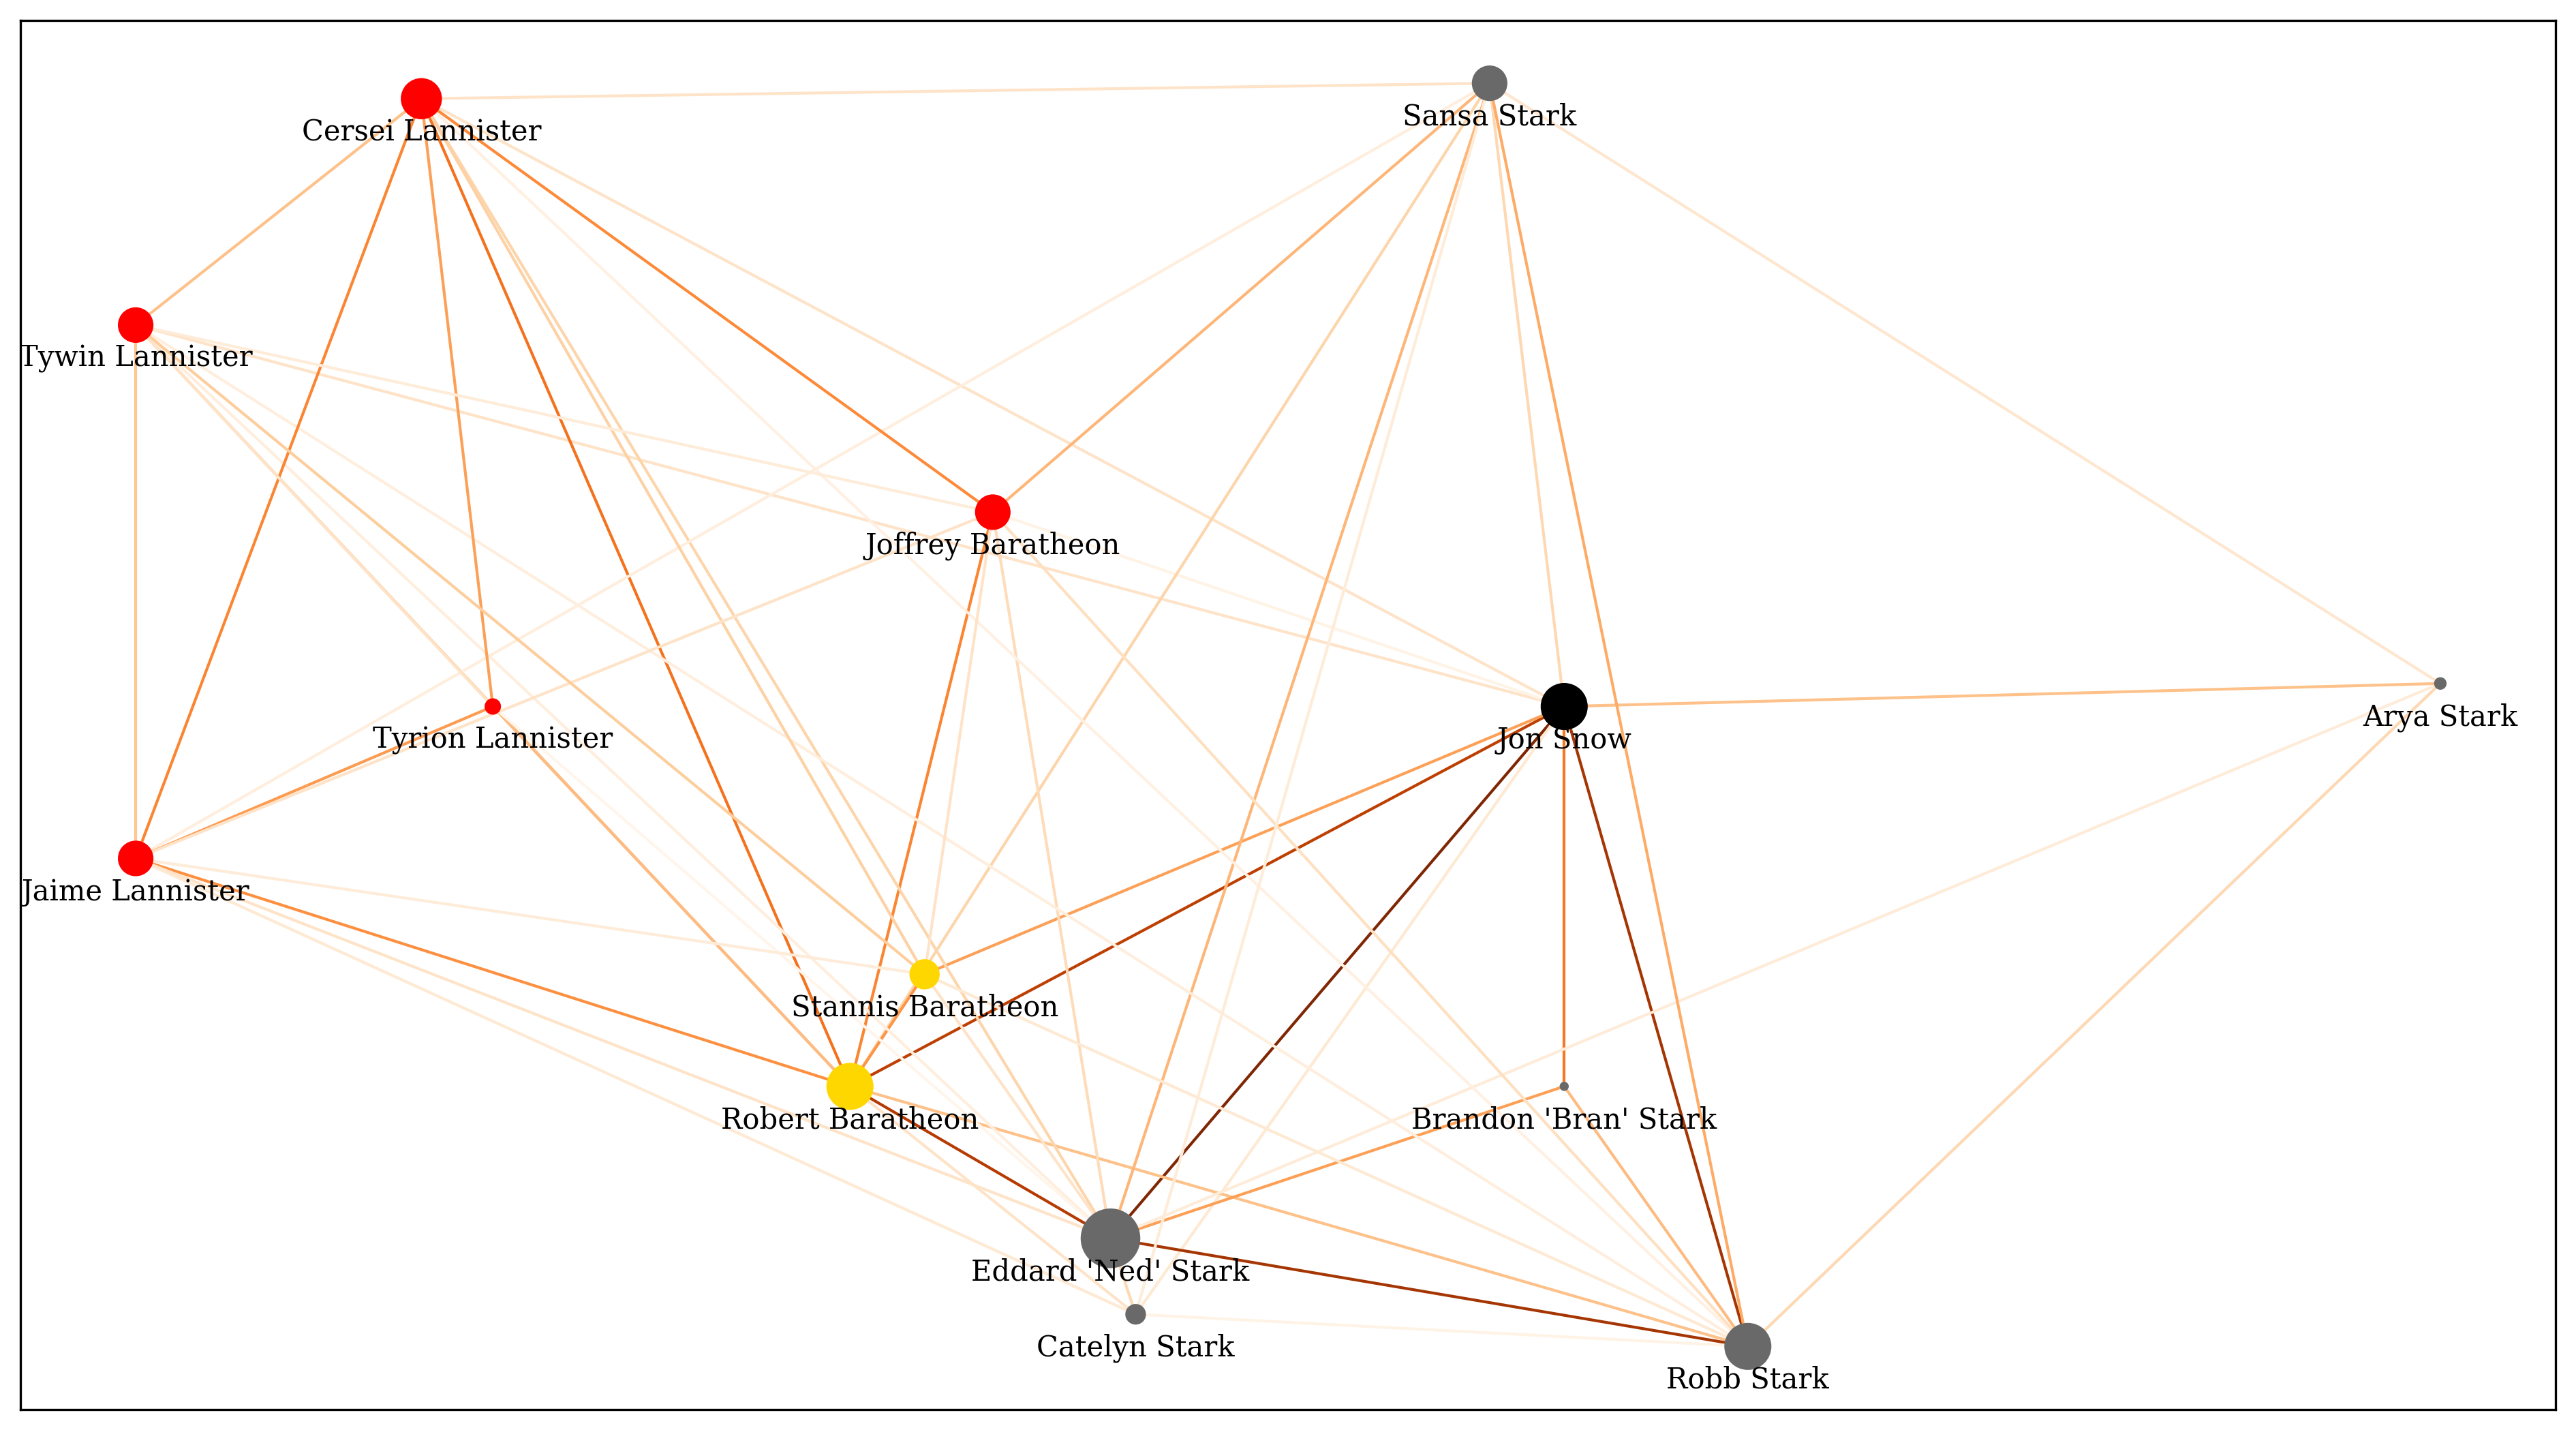

In [25]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_graph(G_book, ax, weight_cutoff=0.2)
plt.show()

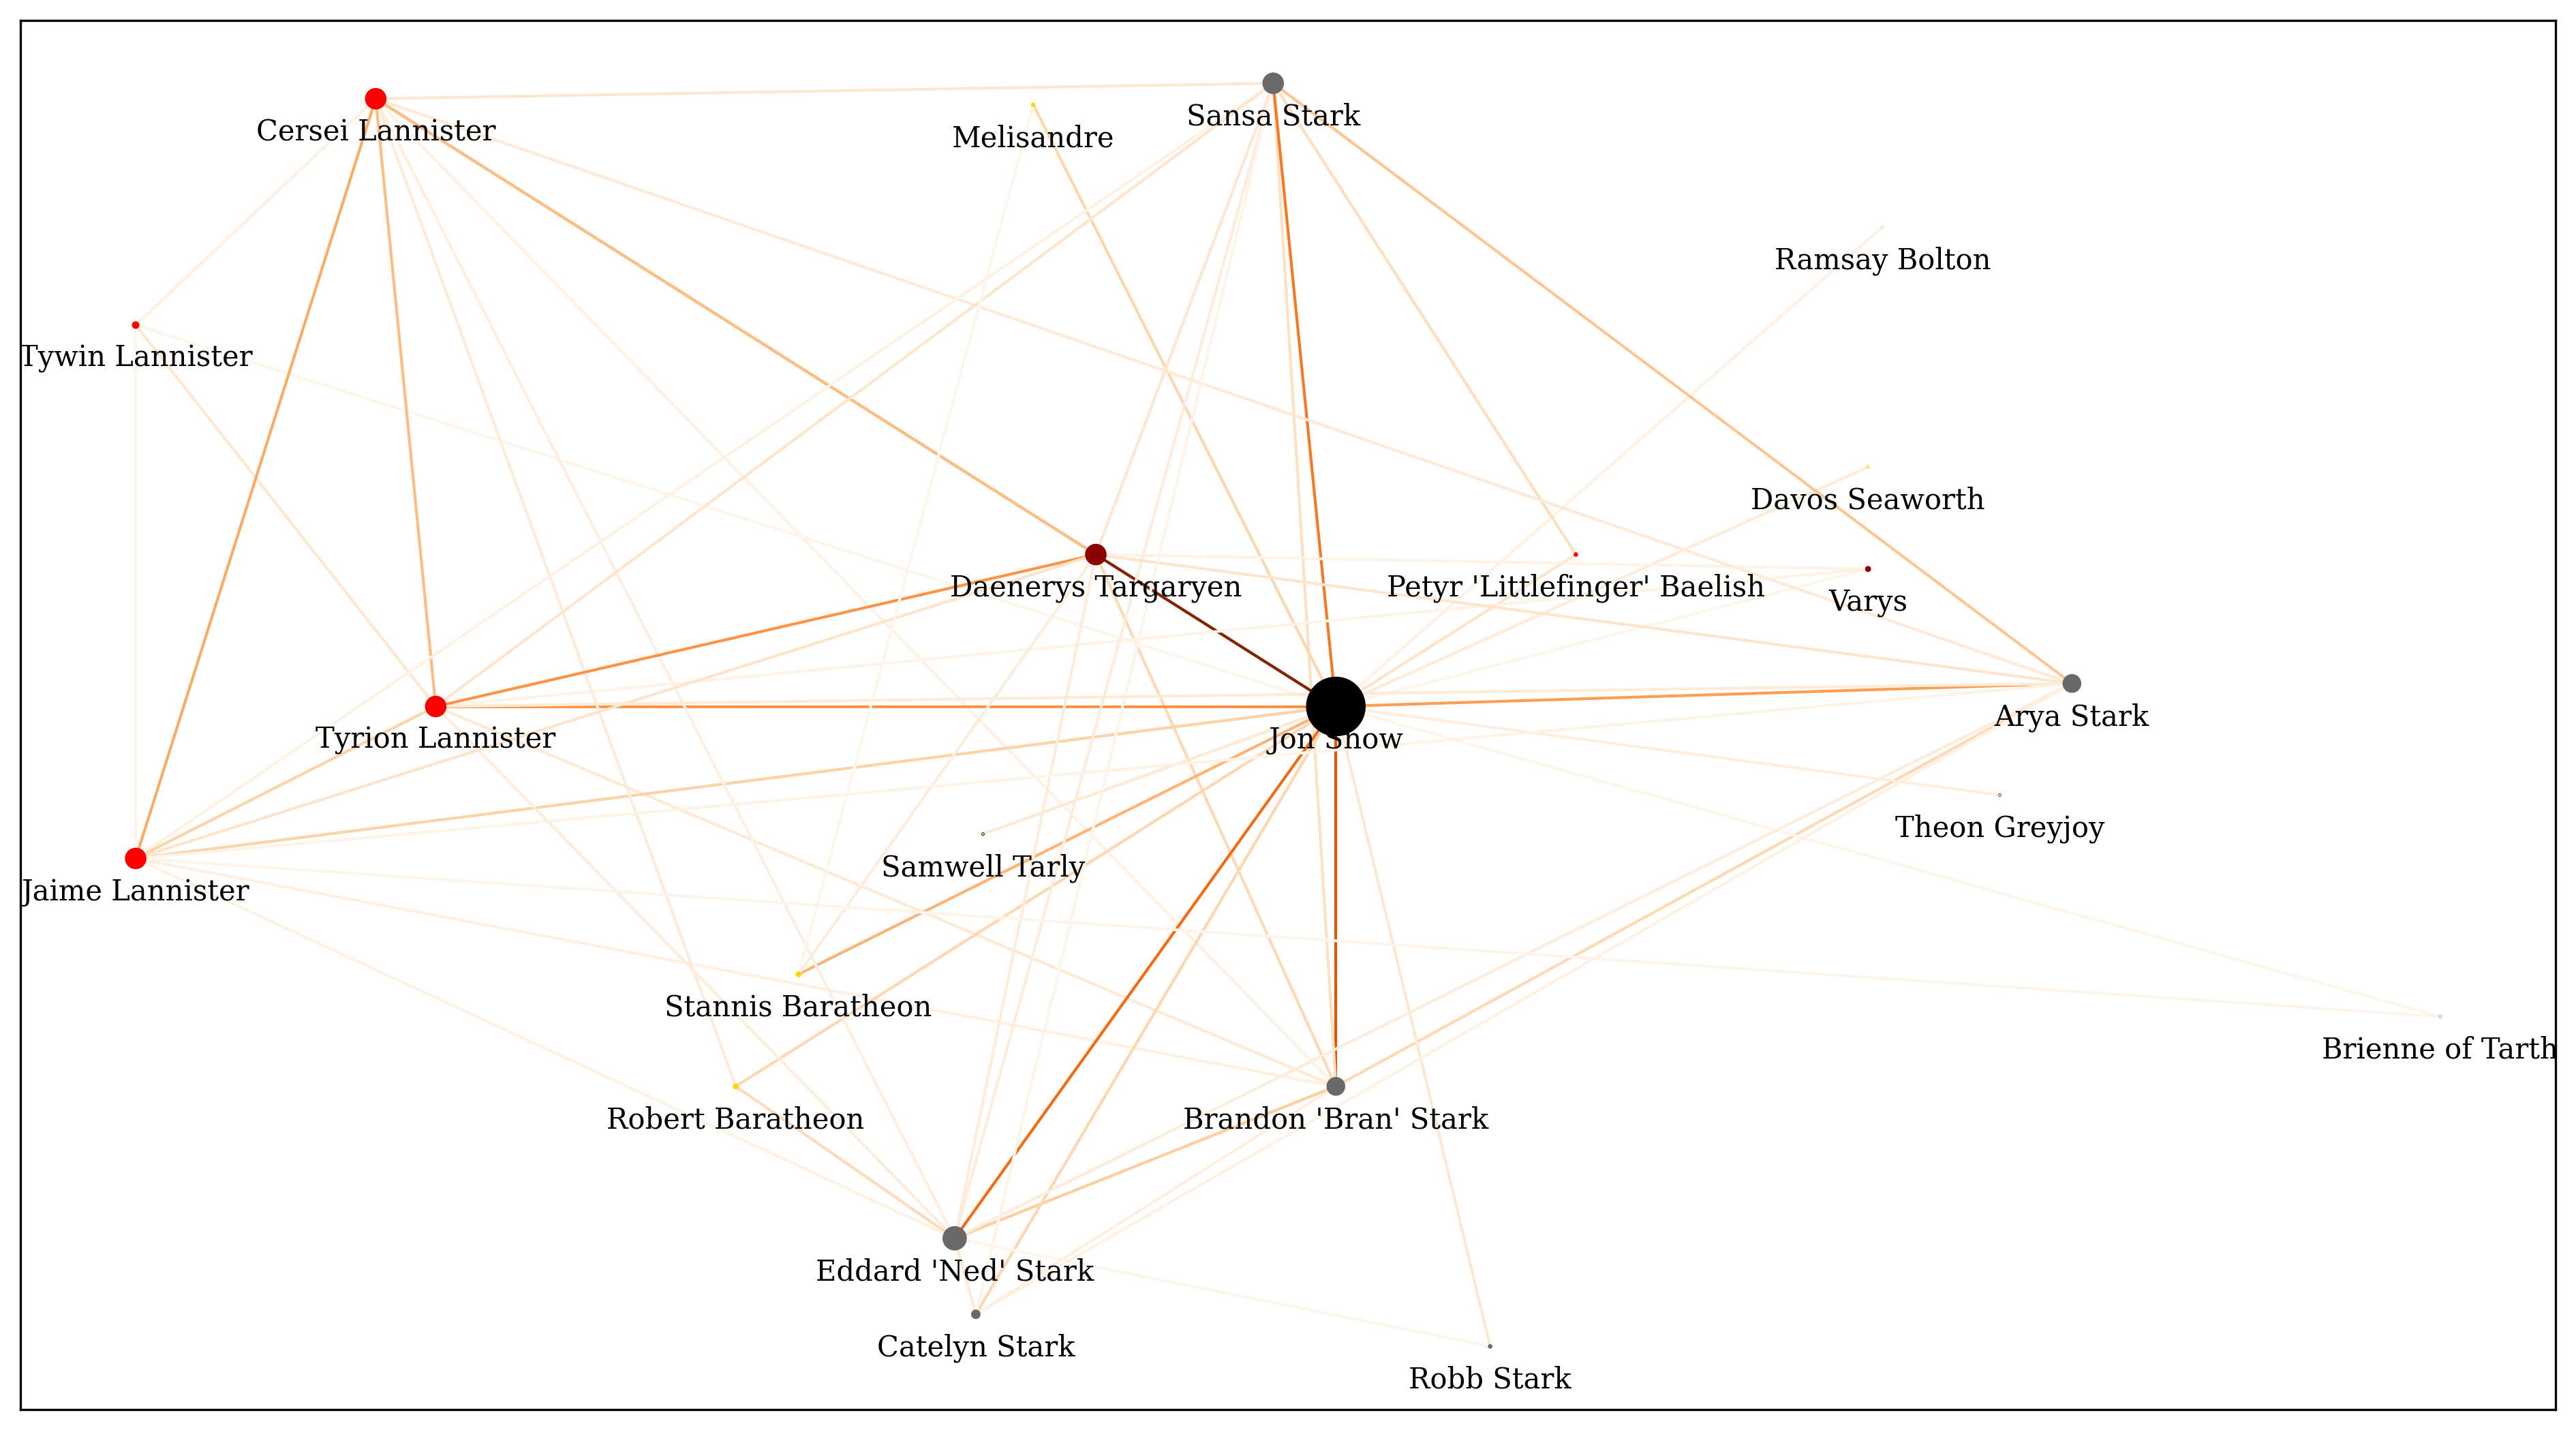

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_graph(G_reddit, ax, weight_cutoff=0.015)
plt.show()

We visualize the weight distributions as we suspect there are big differences in co-occurence proportion in a 358 document corpus and a 70K document corpus.

Weight distribution for Books. Mean: 7.49, std.: 7.87
Weight distribution for Reddit. Mean: 0.67, std.: 0.79


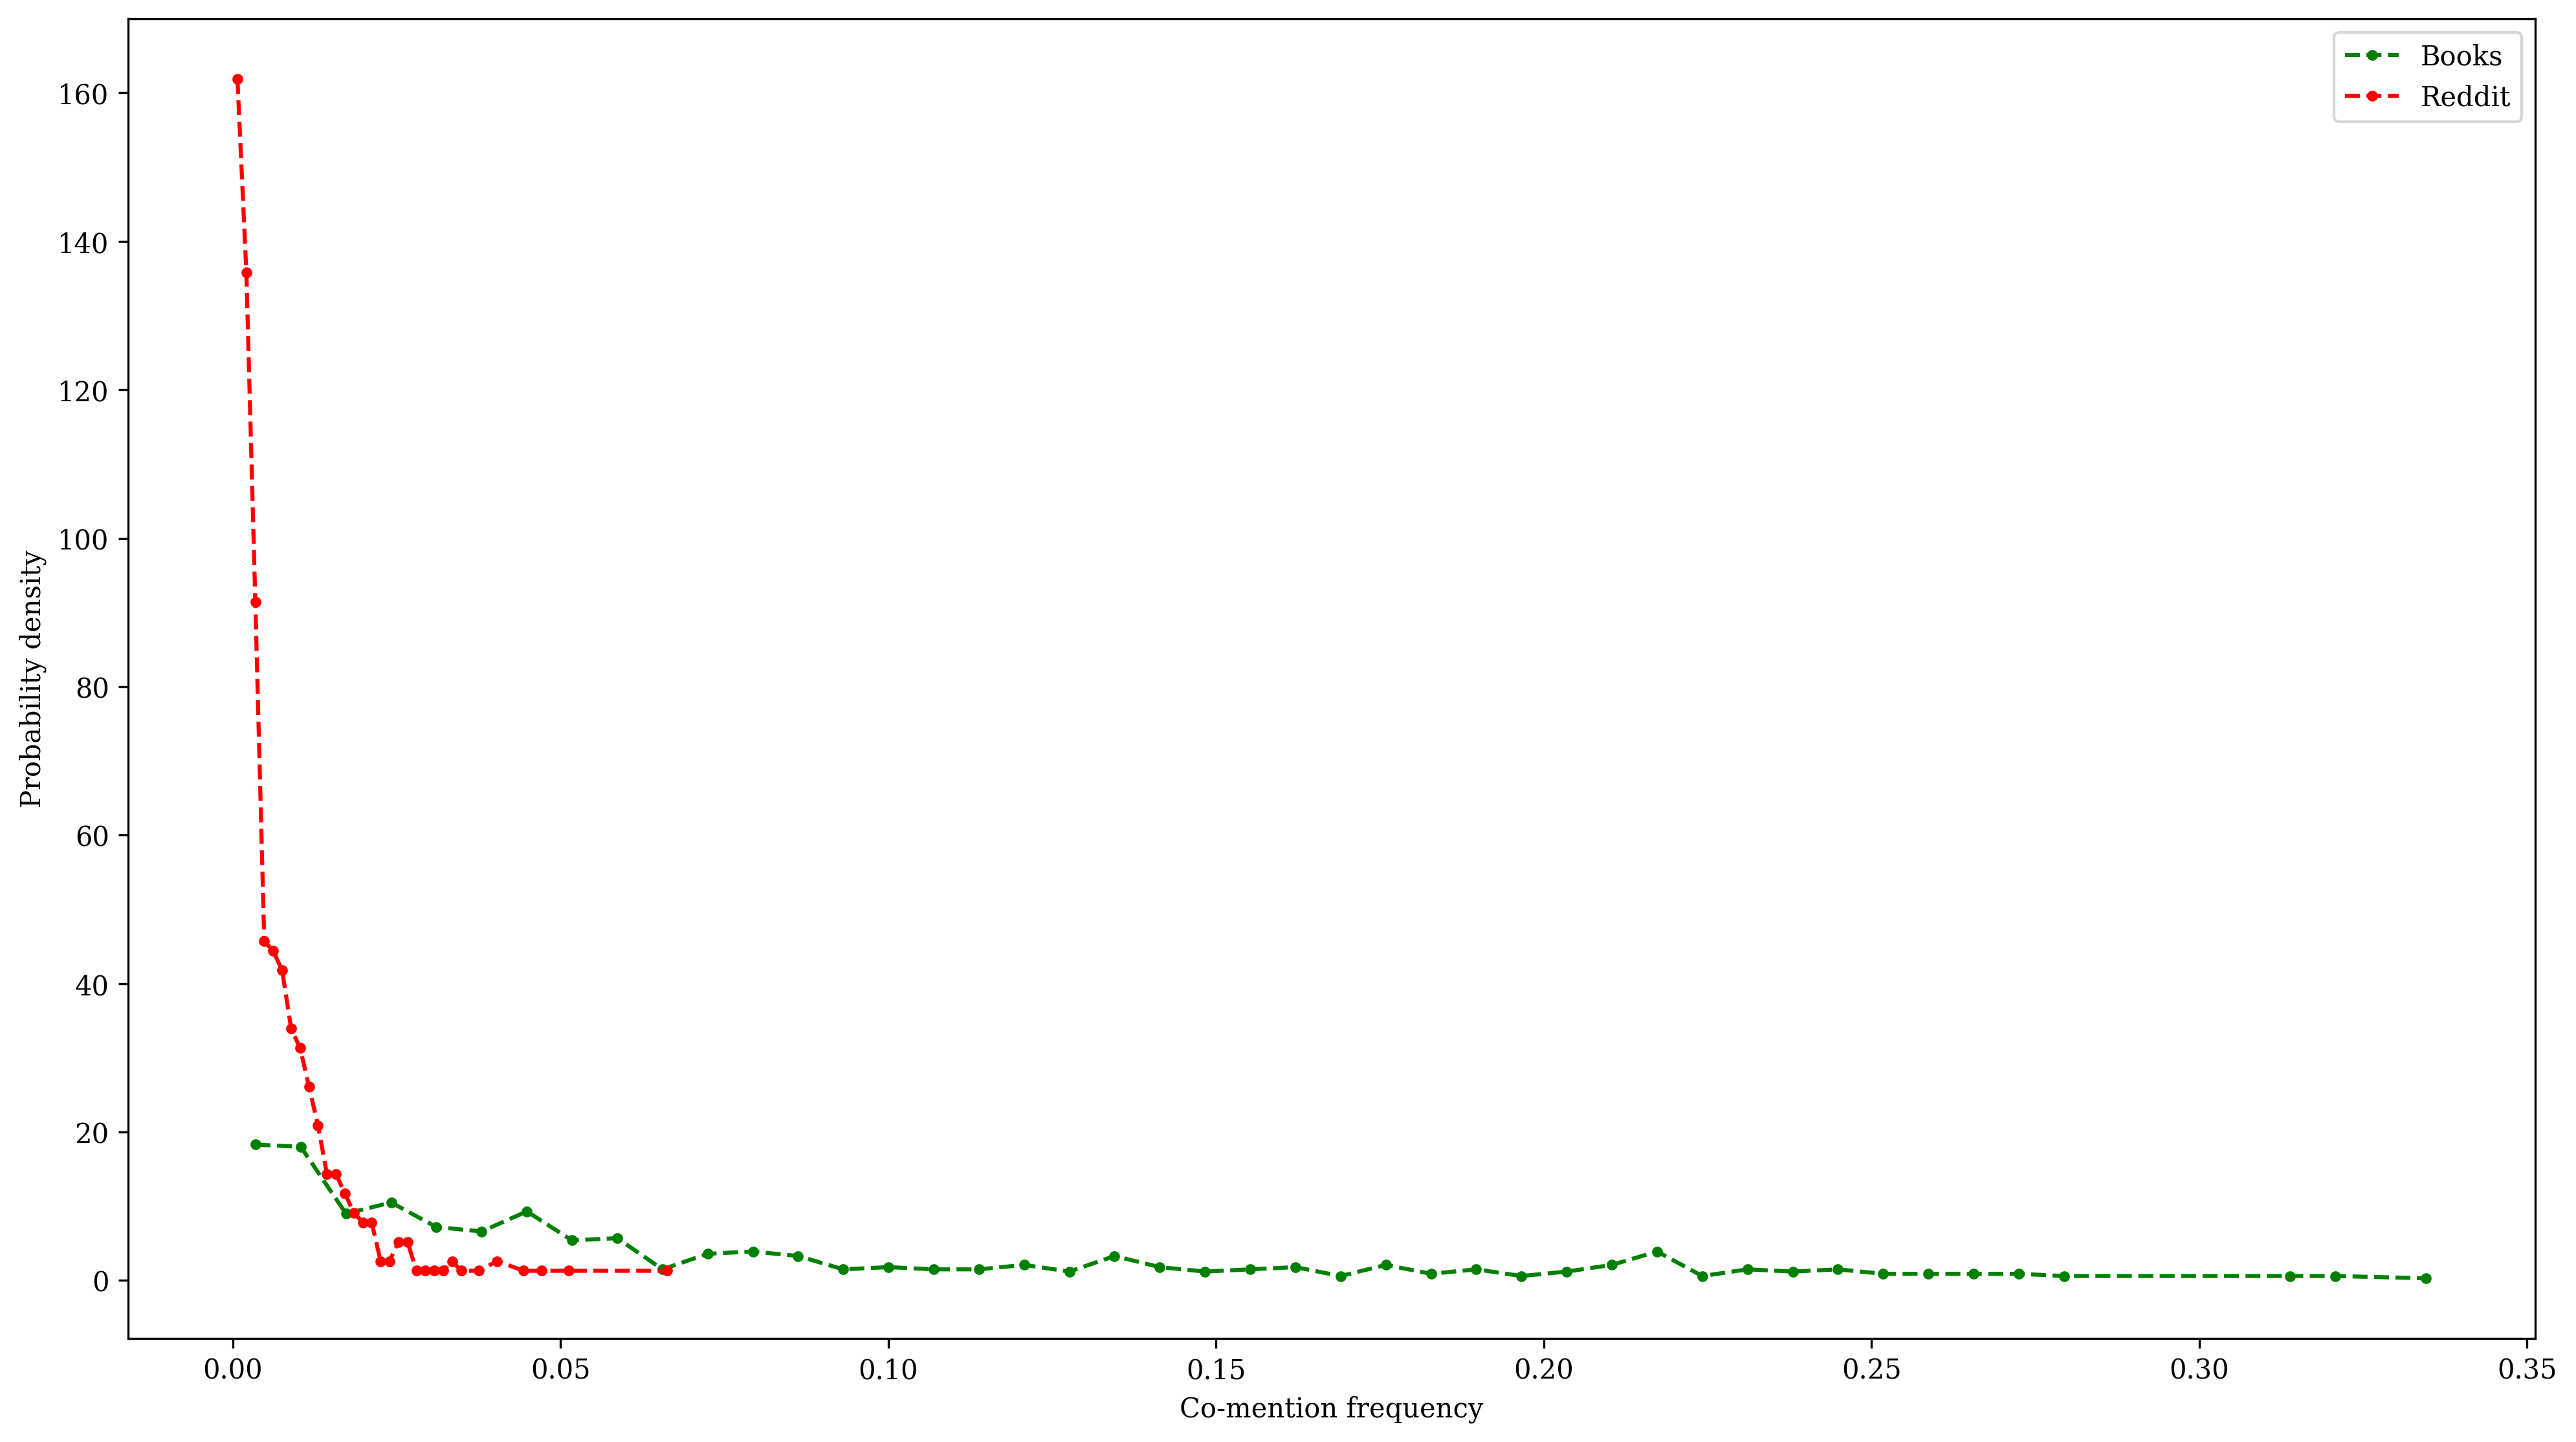

In [17]:
""" Weight distribution """
fig, ax = plt.subplots(figsize = (16, 9))

names = ("Books", "Reddit")
colours = "gr"

n_bins = 50

for i, G in enumerate((G_book, G_reddit)):
    weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))
    bins = np.linspace(0, weights.max(), n_bins)

    hist, edges = np.histogram(weights, bins=bins, density=True)

    x = (edges[1:] + edges[:-1])/2

    ax.plot(x[hist > 0], hist[hist > 0], marker='.', color=colours[i], ls="--", label=names[i])
    
    print(f"Weight distribution for {names[i]}. Mean: {weights.mean()*100:.2f}, std.: {weights.std()*100:.2f}")


ax.legend()
ax.set_xlabel("Co-mention frequency")
ax.set_ylabel("Probability density")

plt.show()

The histograms look very interesting and are discussed in the website. We would like to plot them at log scale to check for power law to compare to social networks, but this was a bit unwieldy for numbers between 0 and 1.

In [4]:
c_book = nx.algorithms.average_clustering(G_book, weight="weight")
c_red = nx.algorithms.average_clustering(G_reddit, weight="weight")
print(f"Book: {c_book*100:.4f}%, Reddit: {c_red*100:.4f}%")

Book: 15.9990%, Reddit: 8.1119%


We choose to calculate average clustering coefficients to get an idea of the connected-ness of these graphs - we use the weighted version which makes the result a bit tricky to interpret when the weight are of this somewhat complex co-occurency form. 

Below is an attempt to work with shortest path which was cut from the website as we had the issue of our weights being similarity measures and not cost measures as is the easiest way to interpret the shortest path. We tried to resolve this by using $max_weight - weight$ as weight, but this final number is too theoretically shaky.

In [7]:
""" Avg. inverted shortest paths """
inverted_shortest = list()
for G in (G_book, G_reddit):
    G_inverted = G.copy()
    max_w = max(list(nx.get_edge_attributes(G, "weight").values()))
    G_inverted.add_weighted_edges_from({
      (*e, max_w-w) for e, w in nx.get_edge_attributes(G, "weight").items()
    })
    inverted_shortest.append(
     max_w-nx.average_shortest_path_length(G_inverted, weight="weight")
    )

print(f"Book: {inverted_shortest[0]*100:.4f}%, Reddit: {inverted_shortest[1]*100:.4f}%")

Book: 4.2138%, Reddit: 0.7216%


This section was the first level of data analysis which we find necessary for any graph work: As clear a visualization as possible coupled with some summary statistics of the graph.

### 3.2 Graph communities

In [8]:
def find_communities(G: nx.Graph):
    partition = community.best_partition(G, weight="weight", random_state=0)
    parts = [[node for node, node_com in partition.items() if node_com == com] for com in set(partition.values())]
    return parts

In [9]:
book_coms = find_communities(G_book)
print(f"Found {len(book_coms)} communities")
print(f"Modularity: {nx.algorithms.community.quality.modularity(G_book, book_coms)}")

Found 3 communities
Modularity: 0.07848149289147471


In [10]:
reddit_coms = find_communities(G_reddit)
print(f"Found {len(reddit_coms)} communities")
print(f"Modularity: {nx.algorithms.community.quality.modularity(G_reddit, reddit_coms)}")

Found 3 communities
Modularity: 0.03574358742533962


#### Reddit Graph Communities

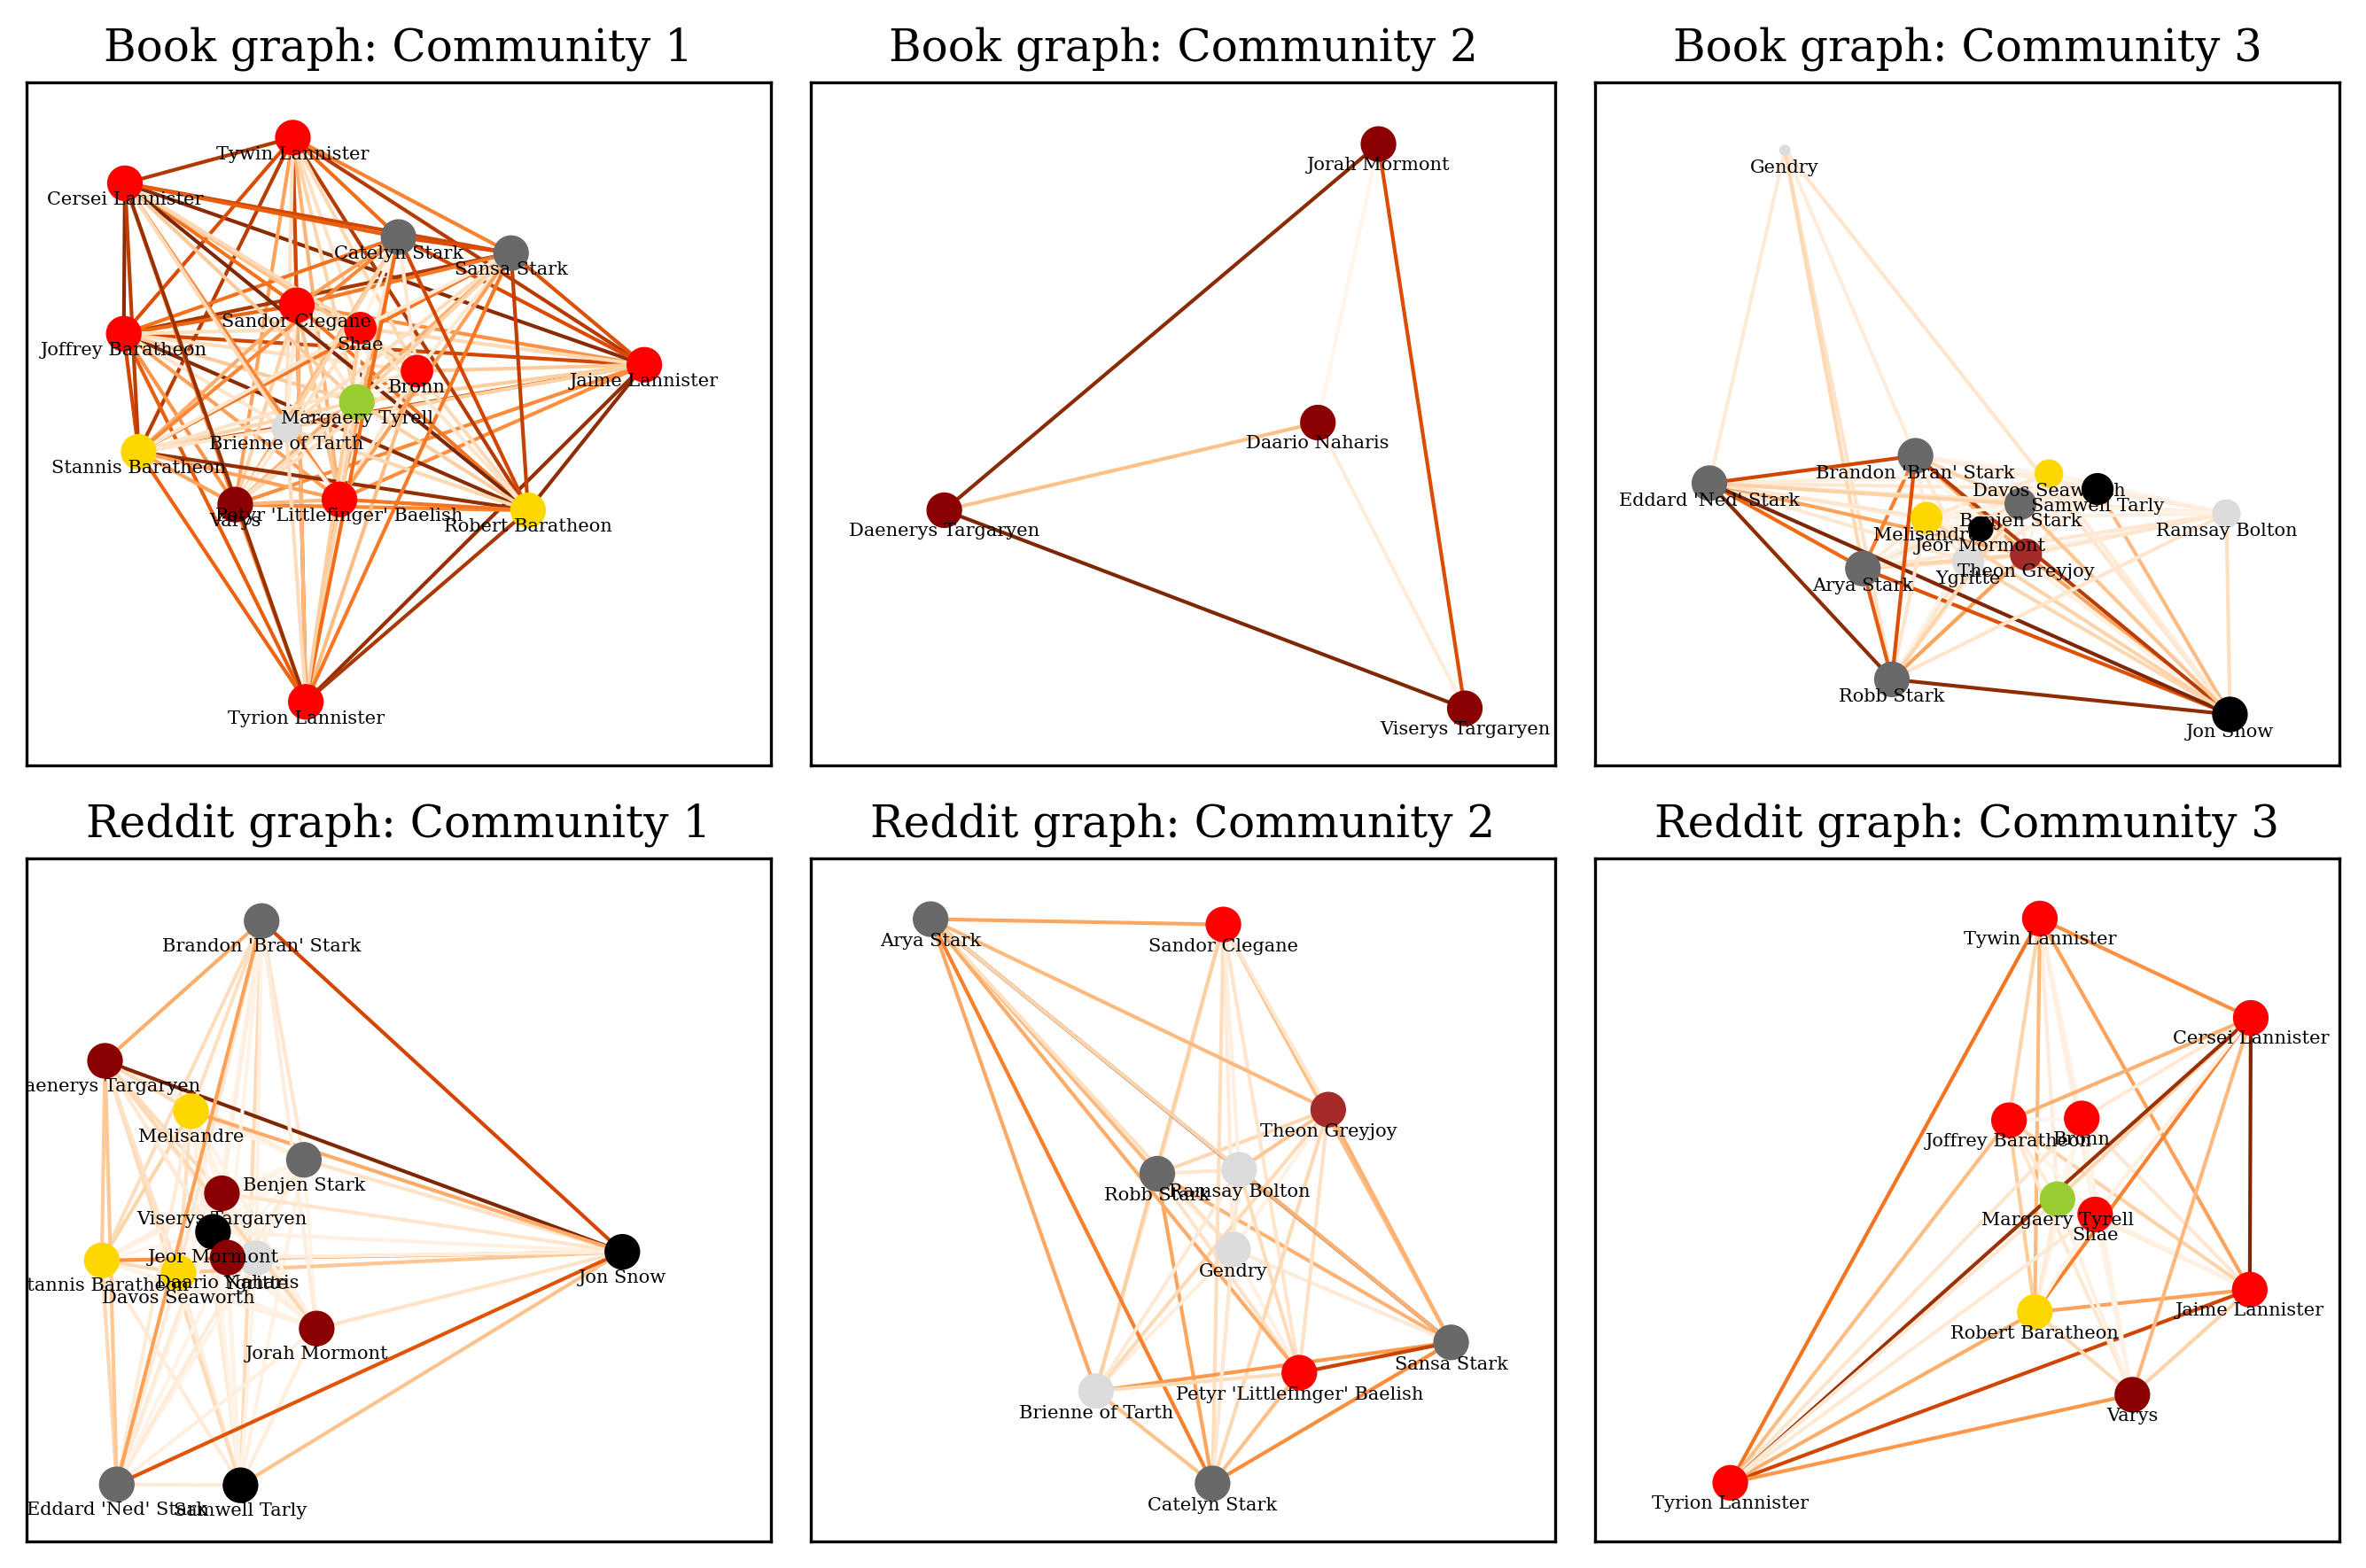

In [13]:
def visualize_communities(G: nx.Graph, communities: list[str], weight_cutoff: float, axes, name):
    for i, (c, ax) in enumerate(zip(communities, axes)):
        H = G.subgraph(c)
        ax.title.set_text(f"{name} graph: Community {i+1}")
        plot_graph(H, ax, weight_cutoff=weight_cutoff, max_node_size=75, font_size=5, pos=nx.layout.kamada_kawai_layout(H, weight="weight"))
        ax.set_xlim([1.3*x for x in ax.get_xlim()])
        ax.set_ylim([1.1*y for y in ax.get_ylim()])
 
fig, axes = plt.subplots(2, len(reddit_coms),  figsize=(9, 6))
visualize_communities(G_book, book_coms, 0, axes[0], "Book")
visualize_communities(G_reddit, reddit_coms, 0, axes[1], "Reddit")
fig.tight_layout(h_pad=1)
plt.show()

#### "Optimal" Graph based on Factions

In [14]:
factions = nx.get_node_attributes(G_book, "faction") # It does not matter if we use G_book or G_reddit here, we only use nodes
faction_names = list(set(factions.values()))
faction_coms = [[n for n in G_book.nodes if factions[n] == faction] for faction in faction_names]
print(f"Factions correspond to {len(faction_coms)} communities")
print(f"Faction modularity on book graph:   {nx.algorithms.community.quality.modularity(G_book, faction_coms)}")
print(f"Faction modularity on reddit graph: {nx.algorithms.community.quality.modularity(G_reddit, faction_coms)}")

Factions correspond to 8 communities
Faction modularity on book graph:   0.024793932421390316
Faction modularity on reddit graph: 0.008421688289545008


In [15]:
for coms, name in zip((book_coms, reddit_coms), ("Book", "Reddit")):
    confusion_mat = np.zeros((len(coms), len(faction_coms)), dtype=int)
    for i, nodes in enumerate(faction_coms):
        for n in nodes:
            j = next(i for i, nodelist in enumerate(coms) if n in nodelist)
            confusion_mat[j, i] += 1
            
    print(name, "confusion matrix. The columns are", faction_names)
    print(confusion_mat)

Book confusion matrix. The columns are ['Lannister', 'Stark', "Night's Watch", 'Tyrell', 'Greyjoy', 'Targaryan', 'Other', 'Baratheon']
[[9 2 0 1 0 1 1 2]
 [0 0 0 0 0 4 0 0]
 [0 5 3 0 1 0 3 2]]
Reddit confusion matrix. The columns are ['Lannister', 'Stark', "Night's Watch", 'Tyrell', 'Greyjoy', 'Targaryan', 'Other', 'Baratheon']
[[0 3 3 0 0 4 1 3]
 [2 4 0 0 1 0 3 0]
 [7 0 0 1 0 1 0 1]]


In this section, we performed Louvain community detection, plottet the result and calculated the modularity for these partitions. These plots and modularities could then be compared to the "optimal" partition, which in our minds would be that characters only relate to characters of the same faction. This partition would be equivalent to partitioning by color in the graphs seen above. We use the modularity conclusions to conclude that the book graph fits better with the story factions.

### 3.3 Understanding the word choice

Now, we will look at how the words used in the reddit posts relate to those used in the books by modelling wordclouds for each character.

In [16]:
df_book = df_book.rename(columns={"text": "selftext"})
df_book

book             title  \
0       0          PROLOGUE   
1       0              BRAN   
2       0           CATELYN   
3       0          DAENERYS   
4       0            EDDARD   
..    ...               ...   
353     4   THE DRAGONTAMER   
354     4               JON   
355     4  THE QUEEN’S HAND   
356     4          DAENERYS   
357     4          EPILOGUE   

                                              selftext  \
0    PROLOGUE\n\n\n\n“We should start back,” Gared ...   
1    BRAN\n\n\n\n\n\nThe morning had dawned clear a...   
2    CATELYN\n\n\n\n\n\nCatelyn had never liked thi...   
3    DAENERYS\n\n\n\n\n\nHer brother held the gown ...   
4    EDDARD\n\n\n\n\n\nThe visitors poured through ...   
..                                                 ...   
353  THE DRAGONTAMER\n\n\n\n\nThe night crept past ...   
354  JON\n\n\n\n\nLet them die,” said Queen Selyse....   
355  THE QUEEN’S HAND\n\n\n\n\nThe Dornish prince w...   
356  DAENERYS\n\n\n\n\nThe hill was a stony island ...   
357  EPILOGUE\n\n\n\n\nI am no traitor,” the Knight...   

                                                 names  
0                         [Robert Baratheon, Jon Snow]  
1    [Robert Baratheon, Eddard 'Ned' Stark, Robb St...  
2    [Robert Baratheon, Eddard 'Ned' Stark, Jon Sno...  
3    [Viserys Targaryen, Jorah Mormont, Daenerys Ta...  
4    [Robert Baratheon, Eddard 'Ned' Stark, Jaime L...  
..                                                 ...  
353                               [Daenerys Targaryen]  
354  [Jon Snow, Robb Stark, Samwell Tarly, Davos Se...  
355  [Catelyn Stark, Daario Naharis, Varys, Daenery...  
356  [Daario Naharis, Viserys Targaryen, Jorah Morm...  
357  [Robert Baratheon, Catelyn Stark, Jon Snow, Ja...  

[358 rows x 4 columns]

In [17]:
df_reddit = df_reddit[:30000]
df_reddit

title  score     created  \
3     (Spoilers extended) This sub is going to explo...      7  1555189915   
7                  [SPOILERS EXTENDED] Miiri’s Prophecy      2  1555187335   
8     (Spoilers Main) GOT Theory: You Can't Trust th...     47  1555186553   
10         (Spoilers extended)The Night King needs Bran      3  1555184407   
16    (Spoilers Extended) Ending theory: a Tudor Wes...    101  1555182090   
...                                                 ...    ...         ...   
8646   Why Arya will be the one to kill Lady Stoneheart      1  1543336184   
8647  What tinfoil theory that is probably wrong do ...      1  1543335716   
8648      A Caution for Young Girls (Spoilers extended)      1  1543335684   
8650  (Spoilers Extended) Question about ruler's con...      1  1543334731   
8651                        (SPOILERS MAIN) Second Sons      1  1543333318   

                  author                                           selftext  \
3       seperationsunday  2019. r/asoiaf is about to E.X.P.L.O.D.E\r\n\r...   
7             ChayaFeige  Miiri Maaz Dur Prophecy decoded using Gilly’s ...   
8        John-on-gliding  The events that led to the creation of the Whi...   
10                dikziw  Ever since the episode where Bran is “marked” ...   
16         5555512369874  ASOIAF has a number of historical inspirations...   
...                  ...                                                ...   
8646       JocelynStark_  \r\n\r\nWell, first I’d like to apologize for ...   
8647           canitryto  Mine is my trial by seven theory for Brandon a...   
8648  gildieoficeandfire  I read the passage on "A Caution for Young Gir...   
8650     Jorg_RedAncrath  So we have this entire exchange between Rhaena...   
8651    TheWhiteWolf1122  Was turning over to Yunkai a ploy as Brown Ben...   

                                                  names  \
3                                                    []   
7                                                    []   
8                                [Brandon 'Bran' Stark]   
10                     [Brandon 'Bran' Stark, Jon Snow]   
16      [Petyr 'Littlefinger' Baelish, Varys, Jon Snow]   
...                                                 ...   
8646  [Eddard 'Ned' Stark, Robb Stark, Jaime Lannist...   
8647                             [Brandon 'Bran' Stark]   
8648                                 [Tyrion Lannister]   
8650                                                 []   
8651                                 [Tyrion Lannister]   

                                                 tokens  
3     [rasoiaf, prepared, disserations, wrote, prepa...  
7     [miiri, maaz, dur, prophecy, decoded, using, g...  
8     [events, led, creation, white, seen, depict, e...  
10    [ever, since, episode, ive, felt, nk, wanting,...  
16    [asoiaf, number, historical, prominent, throug...  
...                                                 ...  
8646  [first, id, apologize, grammar, english, isnt,...  
8647  [mine, trial, seven, theory, brandon, rhaegar,...  
8648  [read, passage, a, caution, young, girls, seem...  
8650  [entire, exchange, rhaena, franklyn, farman, r...  
8651  [turning, yunkai, ploy, brown, ben, plumm, say...  

[5000 rows x 7 columns]

For the reddit data, we only exract the first 30000 posts, since it became too computationally difficult to run on the entire corpus of reddit data.

In [18]:
# Prepare regex and stop-words for clean-up of tokens
url = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
num = r"\d"
punct = r"['""!(?.,:;*&_)#\-=\\·\[“”]"
stop_ord = list(stopwords.words("english")) 
stop_ord.extend(['would' , 'could', 'one', 'ser','twoiaf,', 'said','ned','…','“i','“the',' *',' -', 'like','–', '&gt;','*','|','--','•','jon','dany','bran'])
stop_ord = set(stop_ord)
stops = set(stopwords.words("english"))

def tokenize_sub(row):
    """ 
    Takes in a row of the texts in Pandas dataframe and splits the selftext into tokens that are lower-cased
    and filtered for numbers, stop words, punctuations and URL's. We do not perform stemming and lemmatization as
    the full words are easier to understand in analysis than just using stems.
    """
    sub = row["selftext"]
    tokens = list()
    for w in sub.split():
        w = w.strip().lower()
        if re.search(num, w) or re.search(punct, w) or re.search(url, w) or w in stop_ord:
            continue
        w = re.sub(r"[^a-z]", "", w) 
        tokens.append(w)
    return tokens

df_reddit["tokens"] = df_reddit.apply(tokenize_sub, axis=1)
df_book["tokens"] = df_book.apply(tokenize_sub, axis=1)

We now have dataframe columns in both the reddit and book data that represent the tokens of each post. This will come in handy when finding TF and TF-IDF below.

In [159]:
# Find lowercase name representations from the characters dictionary
L = [name for name in characters.values()]
nameset  = [name.lower() for name in list(chain(*L))]
nameset  = set(nameset)

In [161]:
# Create documents containing every token from every post each character has been mentioned in
docs = {k: list() for k in list(characters)}
for names, tokens in zip(df_book["names"], df_book["tokens"]):
    if names:
        
        for i in range(len(names)):
            docs[names[i]] += tokens

In [272]:
chosen = list(characters.keys())
N = len(chosen)
doc_tfs = dict()
word_docs = defaultdict(lambda: set())
for character in chosen:
    doc = docs[character]
    M = len(doc)
    tfs = dict()
    for w in tqdm(set(doc)):
        tfs[w] = doc.count(w) / M
        word_docs[w].add(character)
    print(
        f"Top 5 TF-terms for {character.upper()}: \t" + ", ".join(
            list(reversed(sorted(tfs, key=tfs.get)))[:5]
        )
    )
    doc_tfs[character] = tfs
doc_freqs = {w: len(d) for w, d in word_docs.items()}
doc_idfs = {
    character: {w: np.log(N/(doc_freqs[w]+1)) for w in set(docs[character])} 
        for character in chosen
    }

  0%|                                                                              | 25/17324 [00:00<02:25, 118.60it/s]

Top 5 TF-terms for EDDARD 'NED' STARK: 	lord, man, men, back, even


  0%|                                                                               | 10/15163 [00:00<02:33, 99.01it/s]

Top 5 TF-terms for ROBERT BARATHEON: 	lord, man, men, back, never


  0%|▎                                                                             | 53/14328 [00:00<00:55, 259.40it/s]

Top 5 TF-terms for JAIME LANNISTER: 	lord, tyrion, man, jaime, back


  0%|▏                                                                             | 36/15503 [00:00<01:27, 177.51it/s]

Top 5 TF-terms for CATELYN STARK: 	lord, man, back, catelyn, men


  1%|▌                                                                             | 78/11076 [00:00<00:28, 379.97it/s]

Top 5 TF-terms for CERSEI LANNISTER: 	lord, tyrion, man, back, never


  1%|▌                                                                              | 64/9209 [00:00<00:14, 633.67it/s]

Top 5 TF-terms for DAENERYS TARGARYEN: 	man, back, old, men, even


  0%|▍                                                                             | 51/10320 [00:00<00:20, 509.99it/s]

Top 5 TF-terms for JORAH MORMONT: 	man, back, jorah, old, told


  0%|▏                                                                             | 30/16807 [00:00<01:55, 144.93it/s]

Top 5 TF-terms for VISERYS TARGARYEN: 	man, back, lord, told, made


  0%|▏                                                                             | 36/15485 [00:00<01:25, 180.47it/s]

Top 5 TF-terms for JON SNOW: 	lord, man, men, back, even


  0%|                                                                                        | 0/14479 [00:00<?, ?it/s]

Top 5 TF-terms for ROBB STARK: 	lord, man, back, men, never


  0%|▏                                                                             | 23/13245 [00:00<00:59, 223.31it/s]

Top 5 TF-terms for SANSA STARK: 	lord, man, back, arya, sansa


  0%|▎                                                                             | 38/10977 [00:00<00:29, 372.56it/s]

Top 5 TF-terms for ARYA STARK: 	lord, arya, man, back, men


  0%|                                                                                        | 0/13483 [00:00<?, ?it/s]

Top 5 TF-terms for THEON GREYJOY: 	lord, man, men, theon, back


  0%|                                                                              | 15/15706 [00:00<01:47, 146.32it/s]

Top 5 TF-terms for BRANDON 'BRAN' STARK: 	lord, man, back, even, men


  0%|▏                                                                             | 34/12345 [00:00<00:37, 331.68it/s]

Top 5 TF-terms for JOFFREY BARATHEON: 	lord, tyrion, man, back, never


  0%|                                                                              | 21/14696 [00:00<01:11, 203.88it/s]

Top 5 TF-terms for SANDOR CLEGANE: 	lord, arya, man, sansa, back


  0%|                                                                              | 18/11426 [00:00<01:04, 176.47it/s]

Top 5 TF-terms for TYRION LANNISTER: 	lord, tyrion, man, jaime, back


  3%|██▍                                                                           | 194/6358 [00:00<00:06, 978.14it/s]

Top 5 TF-terms for PETYR 'LITTLEFINGER' BAELISH: 	lord, tyrion, man, never, king


  1%|▍                                                                              | 54/9003 [00:00<00:16, 537.73it/s]

Top 5 TF-terms for DAVOS SEAWORTH: 	davos, lord, stannis, king, men


  0%|                                                                                | 6/15767 [00:00<04:30, 58.25it/s]

Top 5 TF-terms for SAMWELL TARLY: 	sam, lord, old, man, black


  1%|▍                                                                              | 52/8462 [00:00<00:16, 514.38it/s]

Top 5 TF-terms for STANNIS BARATHEON: 	lord, man, men, never, back


 10%|███████▋                                                                     | 343/3458 [00:00<00:00, 3429.99it/s]

Top 5 TF-terms for MELISANDRE: 	lord, men, davos, stannis, man


  1%|▍                                                                              | 56/9284 [00:00<00:16, 554.49it/s]

Top 5 TF-terms for JEOR MORMONT: 	tyrion, lord, man, old, black


  0%|▏                                                                             | 19/11840 [00:00<01:02, 189.99it/s]

Top 5 TF-terms for BRONN: 	tyrion, lord, man, cersei, never


  1%|▌                                                                              | 58/8685 [00:00<00:15, 574.24it/s]

Top 5 TF-terms for VARYS: 	lord, tyrion, man, king, cersei


  1%|█                                                                             | 121/9104 [00:00<00:14, 610.51it/s]

Top 5 TF-terms for SHAE: 	tyrion, lord, man, back, made


  0%|                                                                              | 22/15798 [00:00<01:13, 214.04it/s]

Top 5 TF-terms for MARGAERY TYRELL: 	lord, cersei, queen, tyrion, man


  1%|▋                                                                              | 57/6656 [00:00<00:11, 561.36it/s]

Top 5 TF-terms for TYWIN LANNISTER: 	lord, tyrion, man, back, never


  2%|█▎                                                                           | 115/6727 [00:00<00:05, 1149.94it/s]

Top 5 TF-terms for YGRITTE: 	lord, men, man, black, back


  1%|▌                                                                              | 62/8721 [00:00<00:14, 613.86it/s]

Top 5 TF-terms for GENDRY: 	arya, lord, man, back, even


  2%|█▏                                                                           | 109/7184 [00:00<00:06, 1089.58it/s]

Top 5 TF-terms for BRIENNE OF TARTH: 	jaime, lord, brienne, man, catelyn


  1%|▉                                                                              | 88/7281 [00:00<00:08, 874.73it/s]

Top 5 TF-terms for RAMSAY BOLTON: 	lord, men, theon, man, even


  5%|███▊                                                                         | 300/5976 [00:00<00:03, 1507.41it/s]

Top 5 TF-terms for BENJEN STARK: 	lord, man, old, black, back


100%|████████████████████████████████████████████████████████████████████████████| 5976/5976 [00:04<00:00, 1322.36it/s]


Top 5 TF-terms for DAARIO NAHARAIS: 	barristan, old, hizdahr, man, queen


In [273]:
doc_tf_idf = {
    stock: {w: doc_tfs[stock][w] * doc_idfs[stock][w] for w in set(docs[stock])} 
        for stock in chosen
    }


# Show example of TF and TF-IDF for one character
tf_idf = doc_tf_idf[chosen[0]]
print(f"Top 10 terms for {chosen[0].upper()}")
print(
    f"\tUsing TF:\t" + ", ".join(
        list(reversed(sorted(doc_tfs[chosen[0]], key=doc_tfs[chosen[0]].get)))[:10]
    )
)
print(
    f"\tUsing TF-IDF:\t" + ", ".join(
        list(reversed(sorted(tf_idf, key=tf_idf.get)))[:10]
    )
)

Top 10 terms for EDDARD 'NED' STARK
	Using TF:	lord, man, men, back, even, never, told, made, tyrion, see
	Using TF-IDF:	asha, reek, davos, brienne, meera, bronn, luwin, osha, ramsay, ygritte
Top 10 terms for ROBERT BARATHEON
	Using TF:	lord, man, men, back, never, even, made, tyrion, king, told
	Using TF-IDF:	asha, davos, belwas, brienne, hizdahr, bronn, hotah, daario, kraznys, aeron
Top 10 terms for JAIME LANNISTER
	Using TF:	lord, tyrion, man, jaime, back, never, men, made, even, king
	Using TF-IDF:	brienne, bronn, tyrion, griff, margaery, kevan, creighton, illyrio, merrett, septa
Top 10 terms for CATELYN STARK
	Using TF:	lord, man, back, catelyn, men, never, made, told, even, see
	Using TF-IDF:	brienne, hizdahr, gerris, reznak, varamyr, edmure, haggon, bronn, waif, quentyn
Top 10 terms for CERSEI LANNISTER
	Using TF:	lord, tyrion, man, back, never, jaime, made, even, men, king
	Using TF-IDF:	griff, bronn, brienne, alayne, davos, tyrion, hotah, margaery, arianne, kevan
Top 10 terms 

Documents have been built and we are ready to create the wordclouds.
NOTE: We create 68 word clouds, resulting in a notebook that is very impractical.
This output is removed and can be seen at https://github.com/sorenmulli/graph-of-thrones/tree/master/data.

In [ ]:
book = True
for name in chosen:
    wordcloud = WordCloud(
        max_font_size=28.5,
        scale = 2,
        background_color="white",
        colormap = "tab10",
    ).generate_from_frequencies(doc_tf_idf[name])
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    #plt.show()
    if book:
        plt.savefig("../data/" + f'{name}_wordcloud_book.png')
    else:
        plt.savefig("../data/" + f'{name}_wordcloud.png')

In [ ]:
book = True
for name in chosen:
    wordcloud = WordCloud(
        max_font_size=28.5,
        scale = 2,
        background_color="white",
        colormap = "tab10",
    ).generate_from_frequencies(doc_tfs[name])
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    #plt.show()
    if book:
        plt.savefig("../data/" + f'{name}_TF_wordcloud_book.png')
    else:
        plt.savefig("../data/" + f'{name}_TF_wordcloud.png')

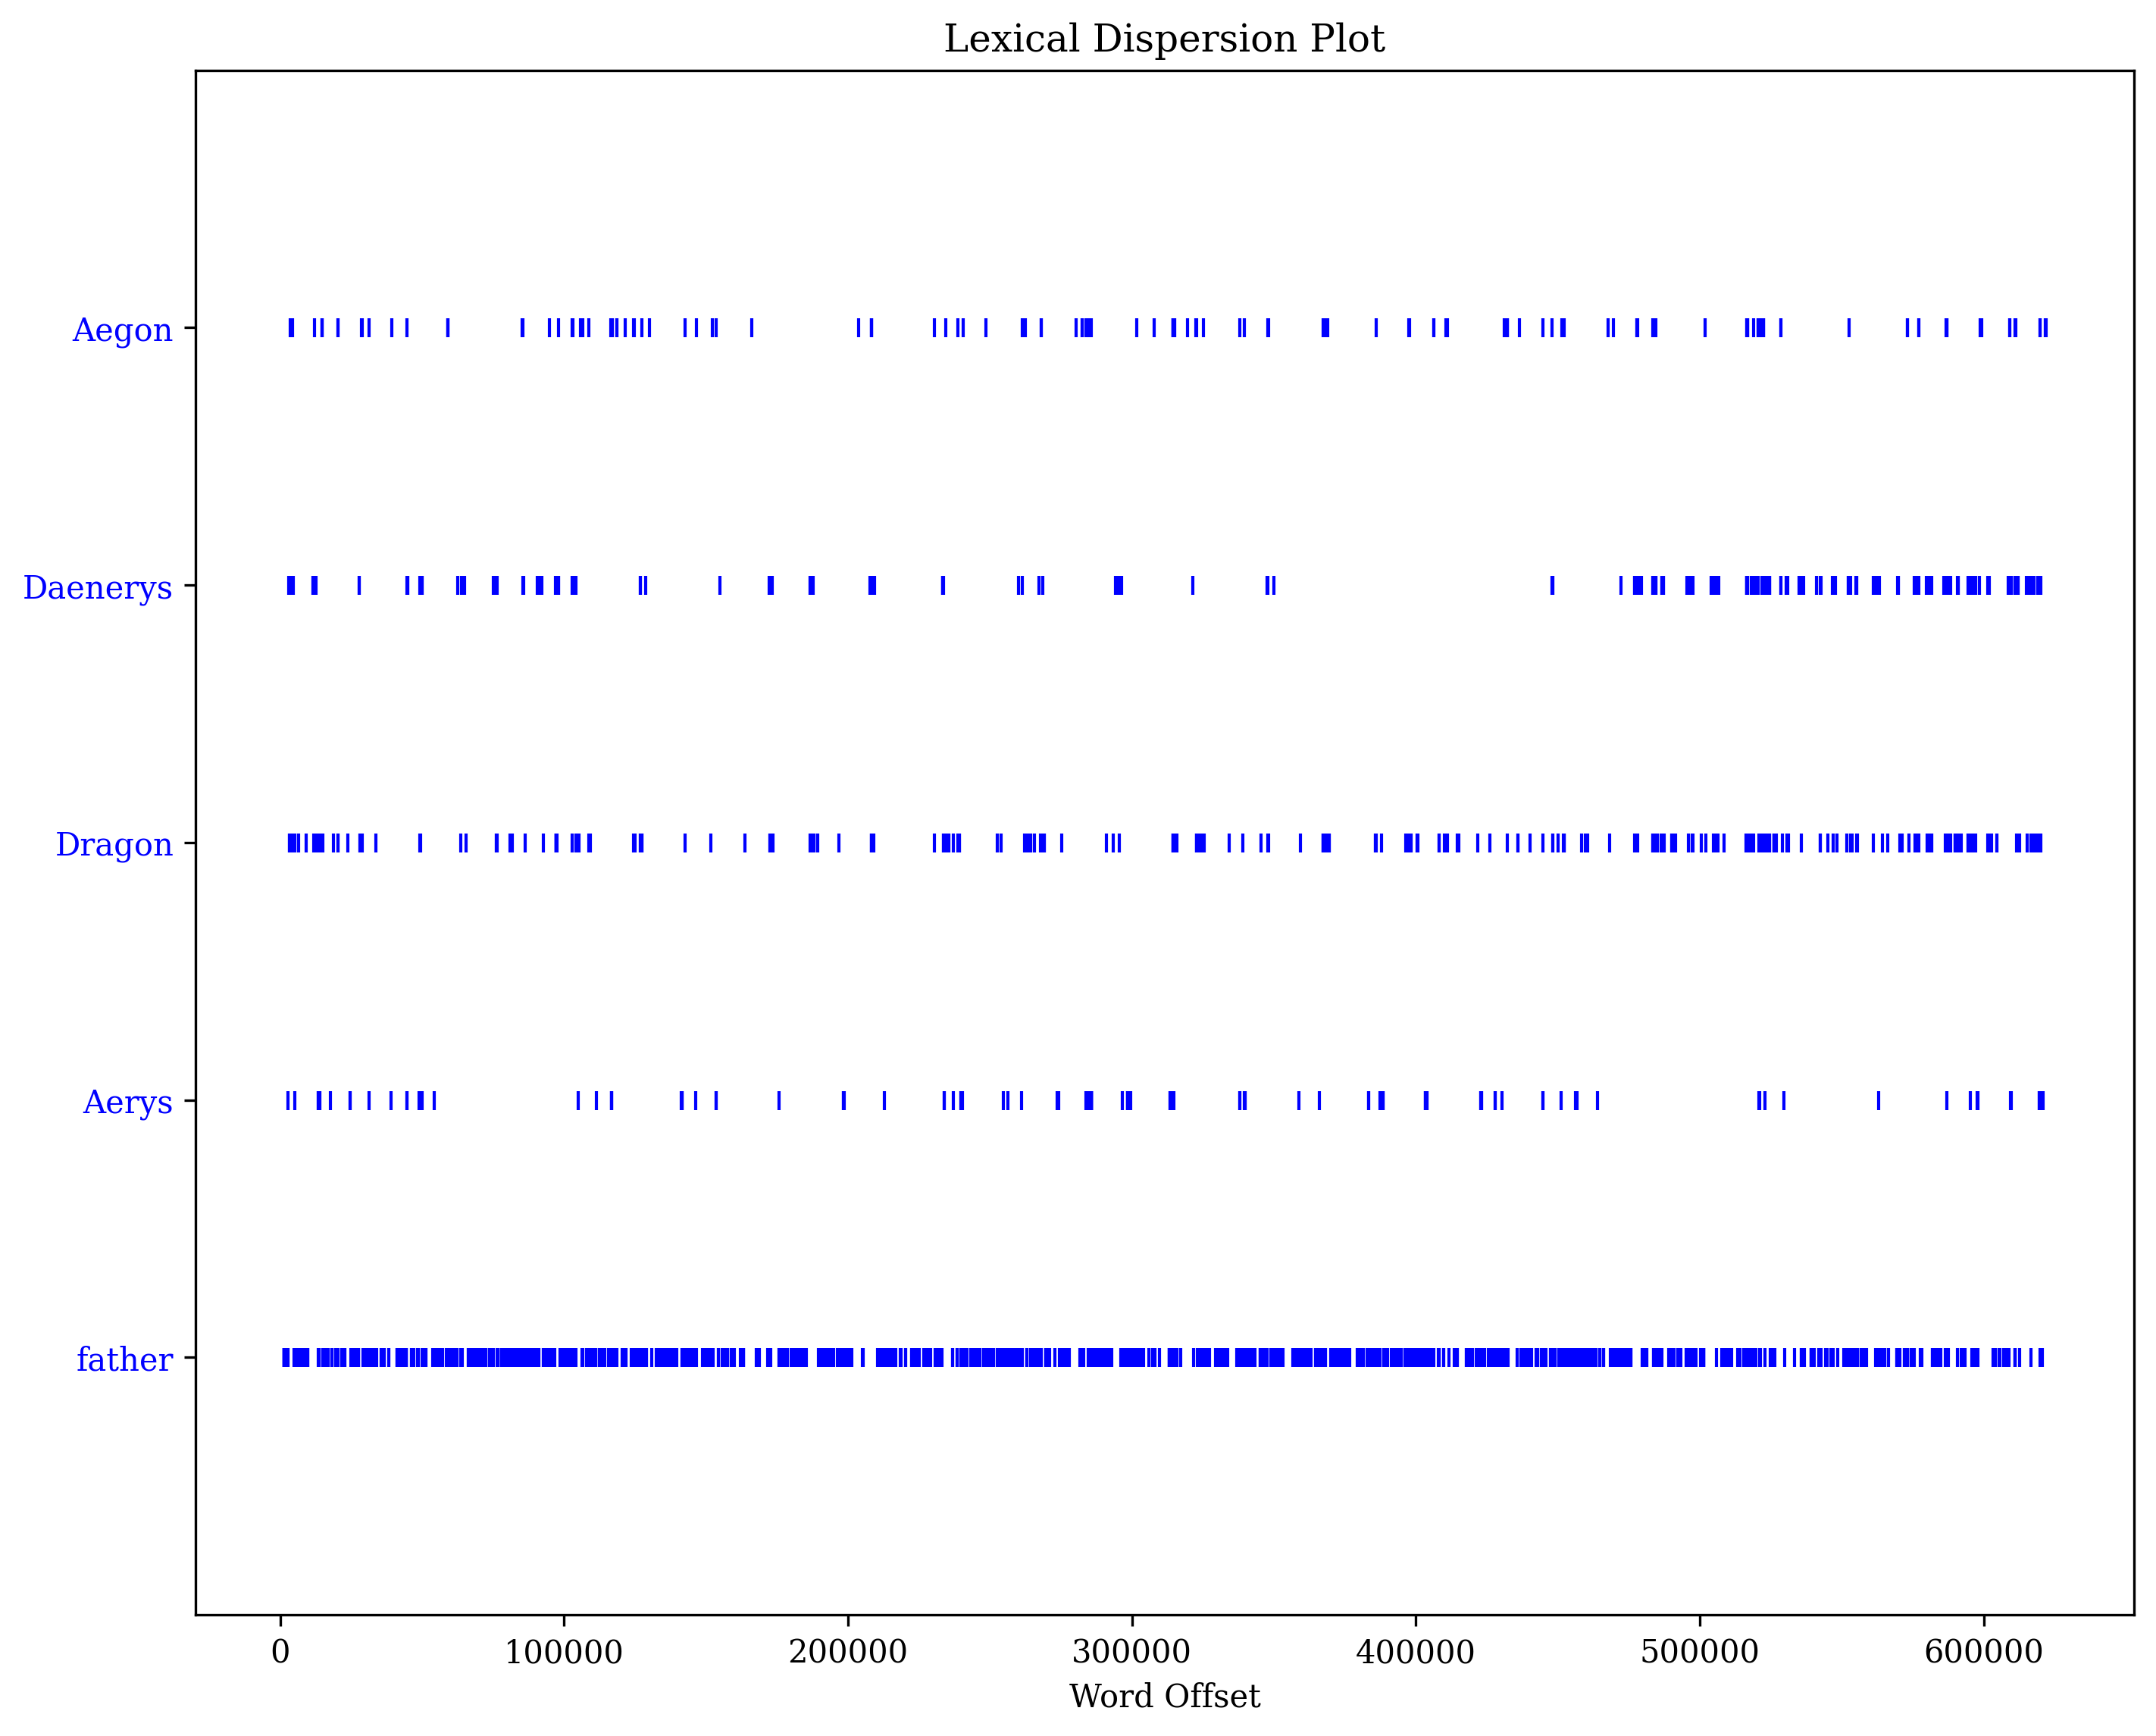

In [40]:
L = [token for token in df_book['tokens']]
tokens  = [name.lower() for name in list(chain(*L))]
text = Text(tokens)
fig = plt.figure(figsize=(11, 9))
interesting_words = ["Aegon", "Daenerys", "Dragon", "Aerys", "father"]
dplot = dispersion_plot(text, interesting_words, ignore_case=True, title='Lexical Dispersion Plot')

Since we have access to the redditor discussions about characters in Game of Thrones, we can use the TF and TF-IDF to construct wordclouds and the words which, in the mind of the redditors, describe the characters and compare these results to how the characters are actually described in the book. We can also use dispersion plots to see how some of the most used words are distributed in the texts. This would make it possible for us to see if redditors who discuss the books adopt the language from the books. TF works by finding the words that are used most in a document independent of importance, while TF-IDF multiplies with the inverse document frequency to get a measure of actual importance in the document, since occurence of rare words are probably important.

We see that the TF-IDF wordclouds have a tendency to bring only very rare/misspelled words - an issue which we believe is caused by the small number of very large documents with considerable overlap making it so that the defining words of characters also occur in other documents. For this reason, TF looks to perform better and give more interesting wordclouds on our data, and these will be placed on our website, so readers can play a game of guessing a character based on their wordcloud.

### 3.4 Sentiment Analysis

We now want to take a look at reddit's sentiment for characters using sentiment analysis, as this will help us understand some of the differences between how the characters graph looks in Reddit compared to the book: That is, are some characters over represented, because the readers seem to hold them in high esteem?

#### 3.4.1 Dictionary-based Methods

In [140]:
df_reddit = pd.read_csv("local_data/reddit.csv")
df = pd.read_csv("local_data/hedonometer.csv", header = 0)

# Making dictionary-based run faster
happi_dict = dict(zip(df["Word"], df["Happiness Score"]))

# Load dataset of word polarities for vader
vader = pd.read_csv('local_data/vader_lexicon.txt', delimiter = "\t", names=["token", "sentiment", "sd", "human sentiment"])

# Every character we have worked with
with open('data/characters.json') as json_file:
    dt = json.load(json_file)
    character_list = list(dt.keys())

In [141]:
# Combine text
df_reddit["text"] = df_reddit["title"] + " " + df_reddit["selftext"]

# Downloading 
#nltk.download('punkt')
#nltk.download('stopwords')

# Clean data using regex
sw = r"\s?(" + "|".join([x + r"\s" for x in stopwords.words("english")]) + r")"
def clean(s):
    s = re.sub(r"\br\/\w+\S+", "", s)
    s = re.sub(r"\bhttp\S+", "", s)
    s = re.sub(r"[^a-zA-Z\s]", "", s.lower())
    s = re.sub(sw, " ", s)
    return s
df_reddit["tokens"] = [nltk.word_tokenize(clean(words)) for words in df_reddit["text"]]

0        [spoiler, extende, sub, going, explode, negati...
1        [spoiler, extende, miir, prophec, miir, maaz, ...
2        [spoiler, m, go, theor, can, trus, children, e...
3        [spoiler, extended, nigh, king, need, br, ever...
4        [spoiler, extende, ending, theor, tud, westero...
                               ...                        
72085    [spoiler, tv, s, directi, unhapp, sans, switch...
72086    [spoiler, nee, help, finding, stann, quote, s,...
72087    [spoiler, didn, realize, much, foreshadowing, ...
72088    [spoiler, ago, sans, chapter, foreshadow, az, ...
72089    [spoiler, woul, sacrifice, rea, twow, nex, wee...
Name: tokens, Length: 72090, dtype: object

Examples of the tokenized words can be seen above, where we see that the data looks clean and ready to find sentiments for.

In [142]:
# Calculate happiness score using hedonometer
def happi(tokens):
    happi_score = []
    for token in tokens:
        try:
           happi_score.append(happi_dict[token])
        except KeyError:
            pass
    return np.mean(happi_score)

# Save happiness score per post on reddit
df_reddit["sentiment"] = [happi(df_reddit["tokens"][i]) for i in range(len(df_reddit))]
df_reddit["sentiment"]

0        5.318667
1        4.811111
2        5.514033
3        5.615057
4        5.446733
           ...   
72085    5.248387
72086    5.696000
72087    5.422195
72088    5.327347
72089    5.292778
Name: sentiment, Length: 72090, dtype: float64

Calculating the sentiment using values in the dictionary of happiness values for common words, we now have the sentiment for each post. We use a simplified hedonometer method where the score is a simple mean for computational effiency.

In [143]:
character_happiness = {}
for character in character_list:
    character_happiness[character] = np.mean([sentiment for i, sentiment in enumerate(df_reddit["sentiment"]) if character in df_reddit["names"][i]])
print("Happiness values for each character:")
character_happiness

Happiness values for each character:


{"Eddard 'Ned' Stark": 5.391891405524405,
 'Robert Baratheon': 5.403114155004241,
 'Jaime Lannister': 5.405715057156195,
 'Catelyn Stark': 5.410103422112807,
 'Cersei Lannister': 5.41158309850199,
 'Daenerys Targaryen': 5.421836231035809,
 'Jorah Mormont': 5.403771640135362,
 'Viserys Targaryen': 5.409461727664311,
 'Jon Snow': 5.40836403369676,
 'Robb Stark': 5.396886702236815,
 'Sansa Stark': 5.401426691646004,
 'Arya Stark': 5.422845739756571,
 'Theon Greyjoy': 5.386697050240641,
 "Brandon 'Bran' Stark": 5.44145375667243,
 'Joffrey Baratheon': 5.382579002578924,
 'Sandor Clegane': 5.404304131075337,
 'Tyrion Lannister': 5.413996434233002,
 "Petyr 'Littlefinger' Baelish": 5.398820147517693,
 'Davos Seaworth': 5.405412559829305,
 'Samwell Tarly': 5.420648588816389,
 'Stannis Baratheon': 5.401750042190074,
 'Melisandre': 5.413159434267152,
 'Jeor Mormont': 5.39681596332409,
 'Bronn': 5.419512721134766,
 'Varys': 5.445146141699171,
 'Shae': 5.426550950111421,
 'Margaery Tyrell': 5.45502

When we loop over each post and mean the sentiment of each post that a character has appeared in for each character, we get the final dictionary-based happiness scores. The numeric values are very close to eachother.

#### 3.4.2 VADER

We want to give this analysis another dimension so we also include the polarity of the post using VADER, which is optimised for social media interactions.

In [ ]:
# Clean data using regex
sw = r"\s?(" + "|".join([x + r"\s" for x in stopwords.words("english")]) + r")"
def clean(s):
    s = re.sub(r"\br\/\a+\S+", "", s)
    s = re.sub(r"\bhttp\S+", "", s)
    s = re.sub(sw, " ", s)
    return s
df_reddit["clean text"] = [clean(text) for text in df_reddit["text"]]

VADER uses sentences instead of tokens, so the data preprocessing is actually easier this time around. Another thing to take note of is that we allow weird symbols in the text, since this lets us get the sentiment of smileys and other symbols.

In [145]:
analyzer = SentimentIntensityAnalyzer()
df_reddit["polarity"] = [analyzer.polarity_scores(sentence)["compound"] for sentence in df_reddit["clean text"]]
df_reddit["polarity"]

0       -0.8541
1        0.0000
2       -0.9902
3        0.8479
4        0.9635
          ...  
72085   -0.3818
72086    0.5256
72087    0.9628
72088    0.9360
72089   -0.5502
Name: polarity, Length: 72090, dtype: float64

We now have access to the polarity of each submission, which already looks more promising that the dictionary-based method, since they contain opposite signs and a larger variance.

In [146]:
vader_character_happiness = {}
for character in character_list:
    vader_character_happiness[character] = np.mean([sentiment for i, sentiment in enumerate(df_reddit["polarity"]) if character in df_reddit["names"][i]])
print("Polarity for each character:")
vader_character_happiness

Polarity for each character:


{"Eddard 'Ned' Stark": -0.012988647692555073,
 'Robert Baratheon': -0.036254630743324516,
 'Jaime Lannister': -0.09214779383053495,
 'Catelyn Stark': -0.060583001856271544,
 'Cersei Lannister': -0.12700622981079834,
 'Daenerys Targaryen': -0.030974646549905043,
 'Jorah Mormont': -0.04753391003460207,
 'Viserys Targaryen': -0.1135689422355589,
 'Jon Snow': -0.04800653230510012,
 'Robb Stark': -0.10439124773960216,
 'Sansa Stark': -0.07997593436645396,
 'Arya Stark': -0.06976353929634167,
 'Theon Greyjoy': -0.18738029595015576,
 "Brandon 'Bran' Stark": 0.0027777600849256882,
 'Joffrey Baratheon': -0.17502902298850578,
 'Sandor Clegane': -0.0965593927893738,
 'Tyrion Lannister': -0.04999401143544988,
 "Petyr 'Littlefinger' Baelish": -0.13317922912205565,
 'Davos Seaworth': -0.07908018433179724,
 'Samwell Tarly': -0.005575938009787928,
 'Stannis Baratheon': -0.1249118001722653,
 'Melisandre': -0.06556564138413142,
 'Jeor Mormont': 0.057982770270270274,
 'Bronn': -0.09086686303387335,
 'Var

Looping over the characters like in the dictionary-based method gives us the final polarities. These do not say much yet, but plotting them will show the full story.

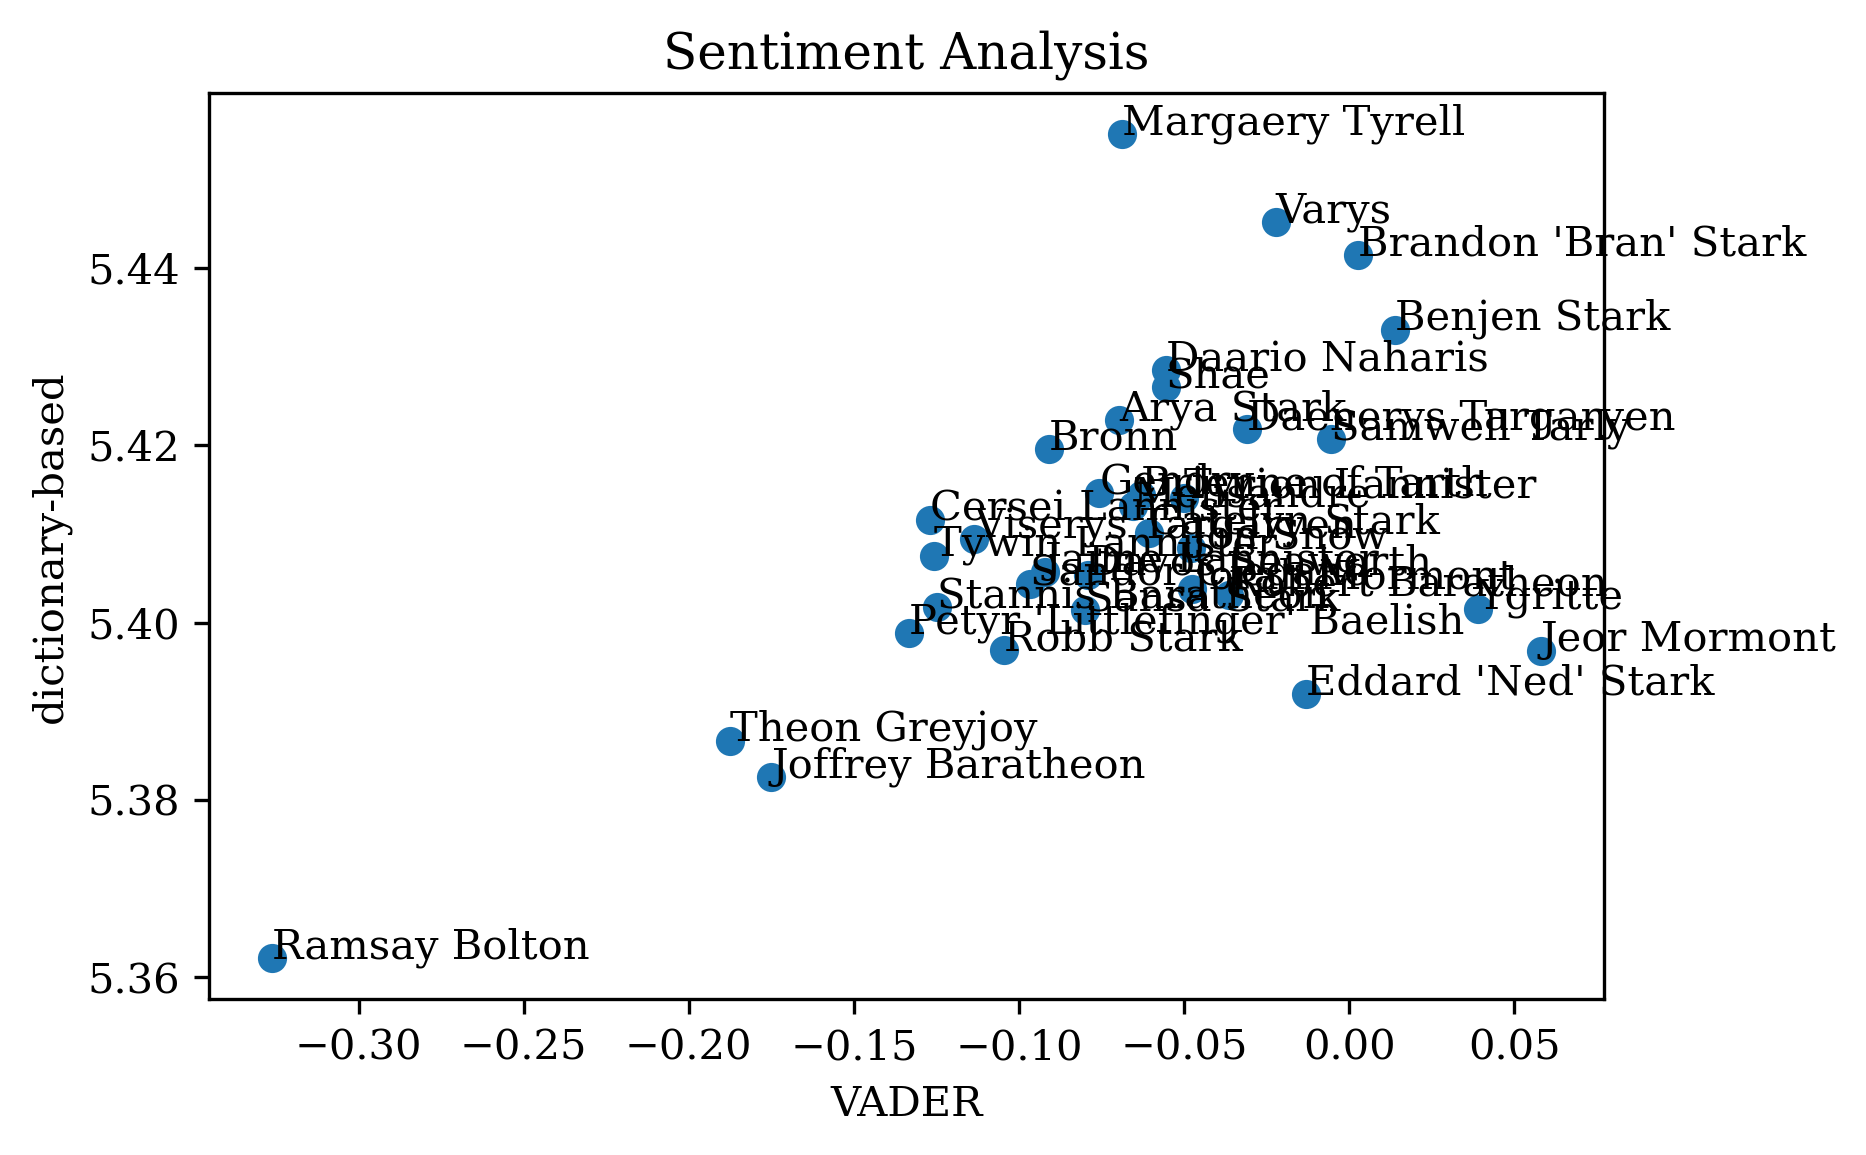

In [147]:
fig, ax = plt.subplots()
ax.scatter(vader_character_happiness.values(), character_happiness.values())


for i, txt in enumerate(character_happiness.keys()):
    ax.annotate(txt, (list(vader_character_happiness.values())[i], list(character_happiness.values())[i]))

ax.set_xlabel("VADER")
ax.set_ylabel("dictionary-based")
ax.set_title("Sentiment Analysis")
plt.show()

This plot looks horrible but gives a bunch of insight. We see that VADER gives more variance in its' predictions, but some correlation seems present even though many character have somewhat neutral polarity.

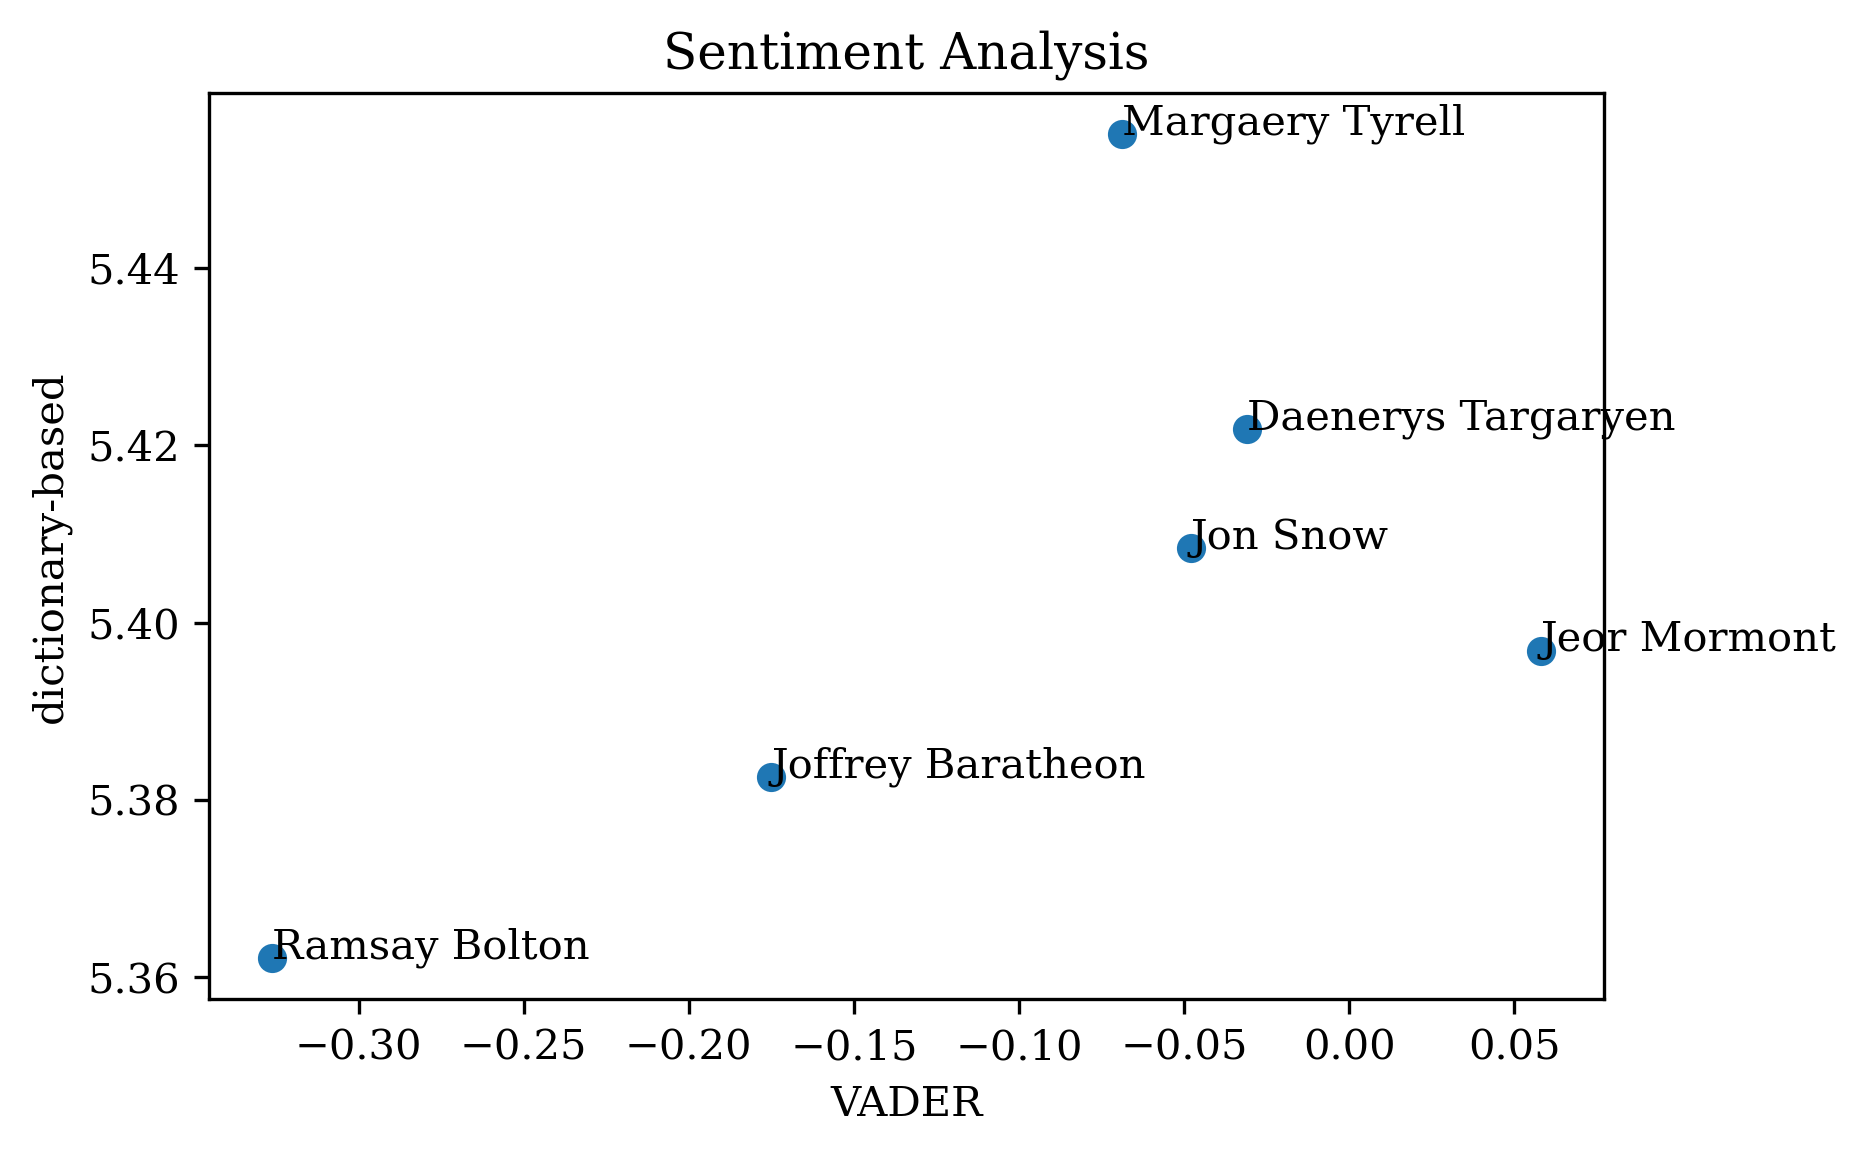

In [148]:
importants = ["Ramsay Bolton", "Jeor Mormont", "Joffrey Baratheon", "Margaery Tyrell", "Daenerys Targaryen", "Jon Snow"]
xs = [value for key, value in vader_character_happiness.items() if key in importants]
ys = [value for key, value in character_happiness.items() if key in importants]
txt = [key for key, value in character_happiness.items() if key in importants]

fig, ax = plt.subplots()
ax.scatter(xs, ys)

for i, txt in enumerate(txt):
    ax.annotate(txt, (xs[i], ys[i]))

ax.set_xlabel("VADER")
ax.set_ylabel("dictionary-based")
ax.set_title("Sentiment Analysis")

plt.show()

The methods used in this section are VADER and dictionary-based methods for finding the redditor sentiment on different characters. This shows which characters redditors like and which they don't. Since we also show both dictionary-based and vader sentiment methods, this allows us to compare these metritcs and get two different perspectives on the sentiment. Using the hedonometer in the dictionary-based method, it is possible to find a sentiment over a list of tokens by looking up the sentiment of each token in the dictionary and adding it to the total sentiment. Doing this for every token for every post on reddit where a character has been mentioned allows for us to get the sentiment of reddit on the character. VADER works in much the same way, though calculating sentiment sentence by sentence and being "specifically attuned to sentiments expressed in social media" instead.

In the first sentiment analysis plot we see above, it is clear that the dictionary-based and VADER methods definitely correlate. We also see that VADER generally explains a lot more about the general sentiment, since the values span from -1 to 1 over a relatively large spectrum. Meanwhile, we see that the dictionary-based method is very stationary and never becomes negative. As for the results of the characters themselves, it is great to see that Ramsey Bolton has the lowest sentiment on both metrics, while Margaery Tyrell and Jeor Mormont have the highest values in one of the two metrics. We also see that Daenerys Targaryen has a pretty average value for both metrics. This might suggest, that she i loved as much as she is hated.

## 3.5 Principal Components

To furhter investigate all of the characters in the series we want to look more at the text describing the characters. For each document created for the characters we can count the amount of times each word in the corpus itself appears in this characters document. For reddit it is all the posts that mention the characters that are considered the document of the character. From the book it is all the chapters in which the character appear. We do this for each character constructing what is known as the bag of words matrix. From here we construct the term by term matrix and find the principal components. The goal is to reduce the dimensionality in order to explain the differences in the characters. We project each of the characters into the space of the first and second principal component.

Due to memory constraints we have chosen only to look at a tiny subset of the data. We used a vocabulary of 10000 words which were randomly selected from each of the text corpuses. However, we still find some interesting results which are elaborated on the website. 

In [19]:
df_reddit = df_reddit[:5000] # We limit the number of data points for PCA
def get_docs(df):
    docs = {k: list() for k in list(characters)}
    for names, tokens in zip(df["names"], df["tokens"]):
        for n in names:
            docs[n].extend(tokens)
    return docs

In [20]:
docs_book = get_docs(df_book)
docs_reddit = get_docs(df_reddit)
len(docs_reddit["Daenerys Targaryen"])

252414

In [21]:
import random
random.seed(0)
def get_vocab(df, k):
    total_vocab = list(set(chain(*[t for t in df_reddit.tokens])))
    return random.sample(total_vocab, k)

book_vocab = get_vocab(df_reddit, 10000)
reddit_vocab = get_vocab(df_reddit, 10000)

In [23]:
def w_count(doc, vocab):
    return np.array([doc.count(w) for w in vocab])

In [24]:
from multiprocessing import Pool

def b_count(doc):
    return w_count(doc, book_vocab)
def r_count(doc):
    return w_count(doc, reddit_vocab)

with Pool(12) as p:
    bow_vectors_book = p.map(b_count, docs_book.values())
with Pool(12) as p:
    bow_vectors_reddit = p.map(r_count, docs_reddit.values())

In [25]:
A_reddit = np.stack(bow_vectors_reddit, axis=1)
A_book = np.stack(bow_vectors_book, axis=1)
print(
    A_reddit.shape,
    A_book.shape
)

(10000, 34) (10000, 34)


In [26]:
def PCA(A: np.ndarray, k: int) -> np.ndarray:
    # Term-by-term matrix
    B = A @ A.T 
    # Principal components and PC vectors
    S, U = np.linalg.eigh(B)
    sort_idx = np.argsort(S)[::-1]
    S, U = S[sort_idx], U[sort_idx]
    # Number of principal components
    Uk = U[:, :k]
    Sk = S[:k]
    # Projection matrix
    P = np.diag(1./np.sqrt(Sk)) @ Uk.T
    # Projected documents
    return P @ A, S

In [27]:
Z_book, S_book = PCA(A_book, 2)
Z_book.shape

(2, 34)

In [28]:
Z_reddit, S_reddit = PCA(A_reddit, 2)
Z_reddit.shape

(2, 34)

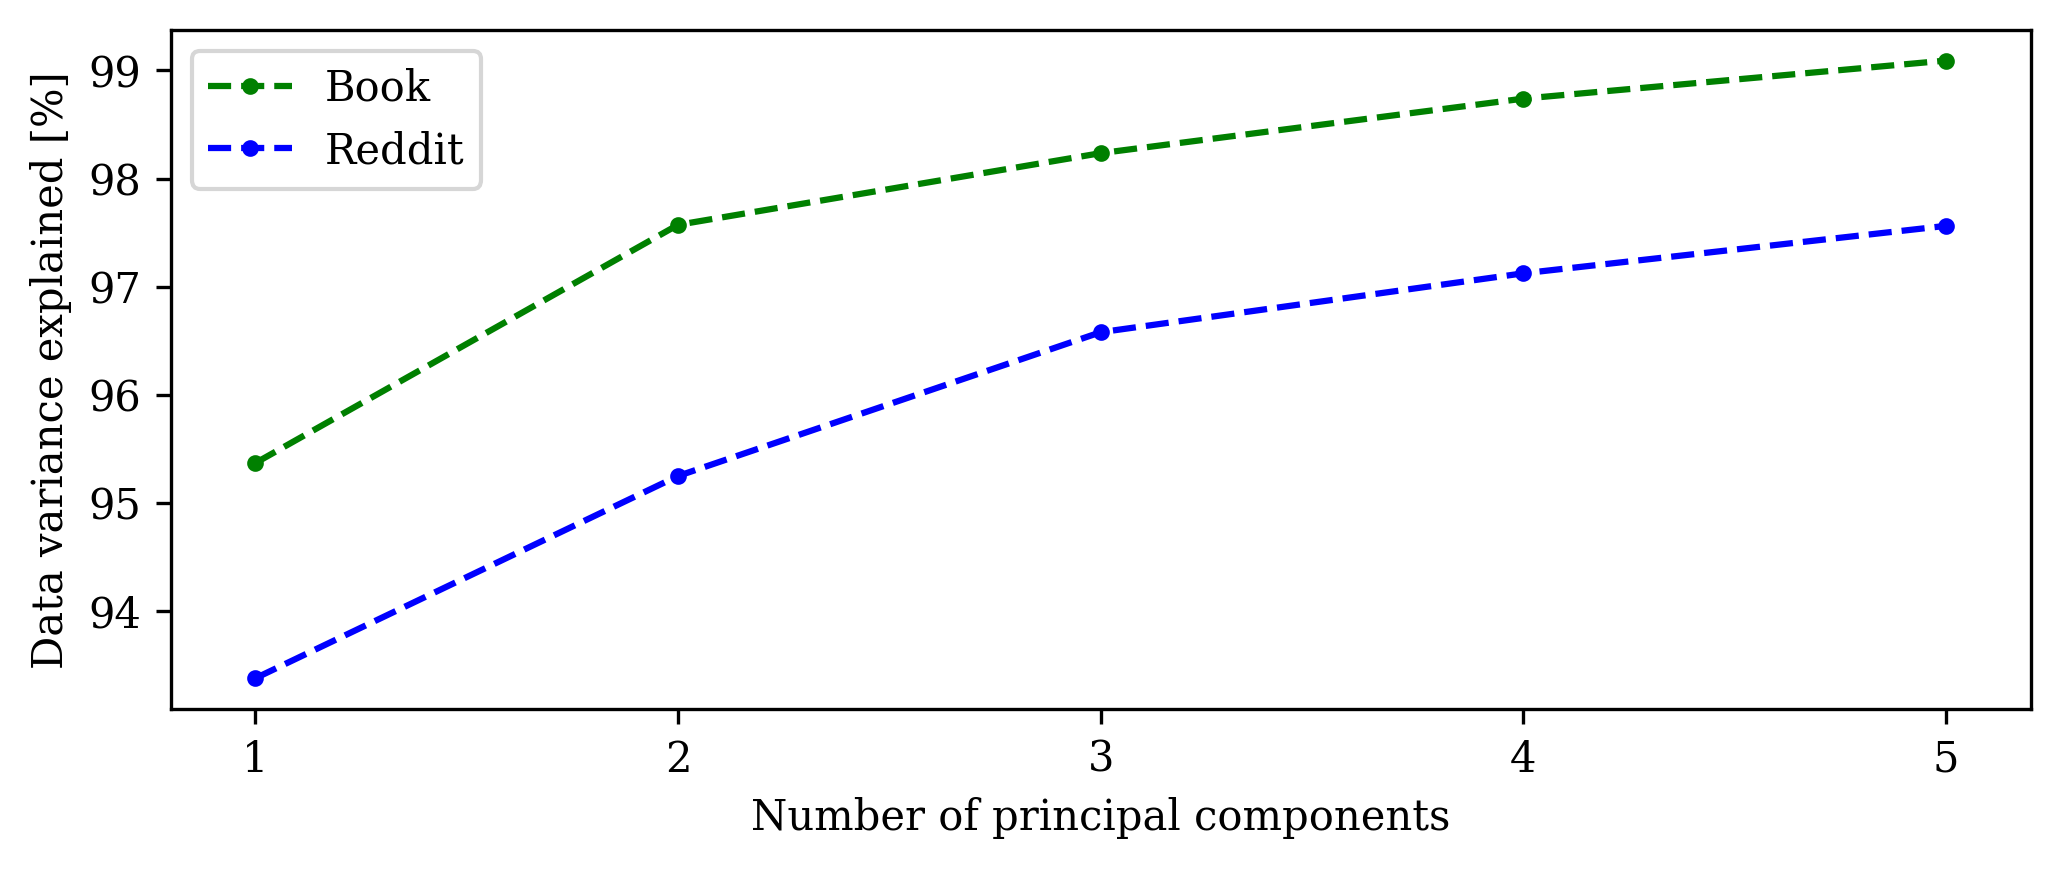

In [29]:
fig, ax = plt.subplots(figsize=(8, 3))
show_k = 5
ax.plot(range(1, show_k+1), 100*np.cumsum(S_book)[:show_k]/np.sum(S_book), color="g", linestyle="--", marker=".", label="Book")
ax.plot(range(1, show_k+1), 100*np.cumsum(S_reddit)[:show_k]/np.sum(S_reddit), color="b", linestyle="--", marker=".", label="Reddit")
ax.legend()
ax.set_xticks(range(1, show_k+1))
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Data variance explained [%]")


plt.show()

In [163]:
with open(os.path.join(DATAPATH, "character_factions.json")) as f:
    char_facts = json.load(f)
with open(os.path.join(DATAPATH, "faction_colours.json")) as f:
    cols = json.load(f)
    
def plot_arrows(Z):
    fig, ax = plt.subplots(figsize=(16, 9))
    for doc, name in zip(Z.T, namedict):
        ax.plot([0, doc[0]], [0, doc[1]], linestyle='--', color=cols[char_facts[name]], alpha=0.5)
        ax.annotate(name, xy=(doc[0], doc[1]), fontsize=10, ha="center", va="top")

        ax.set_xlabel("Principal component dim. 1")
        ax.set_ylabel("Principal component dim. 2")

    plt.show()

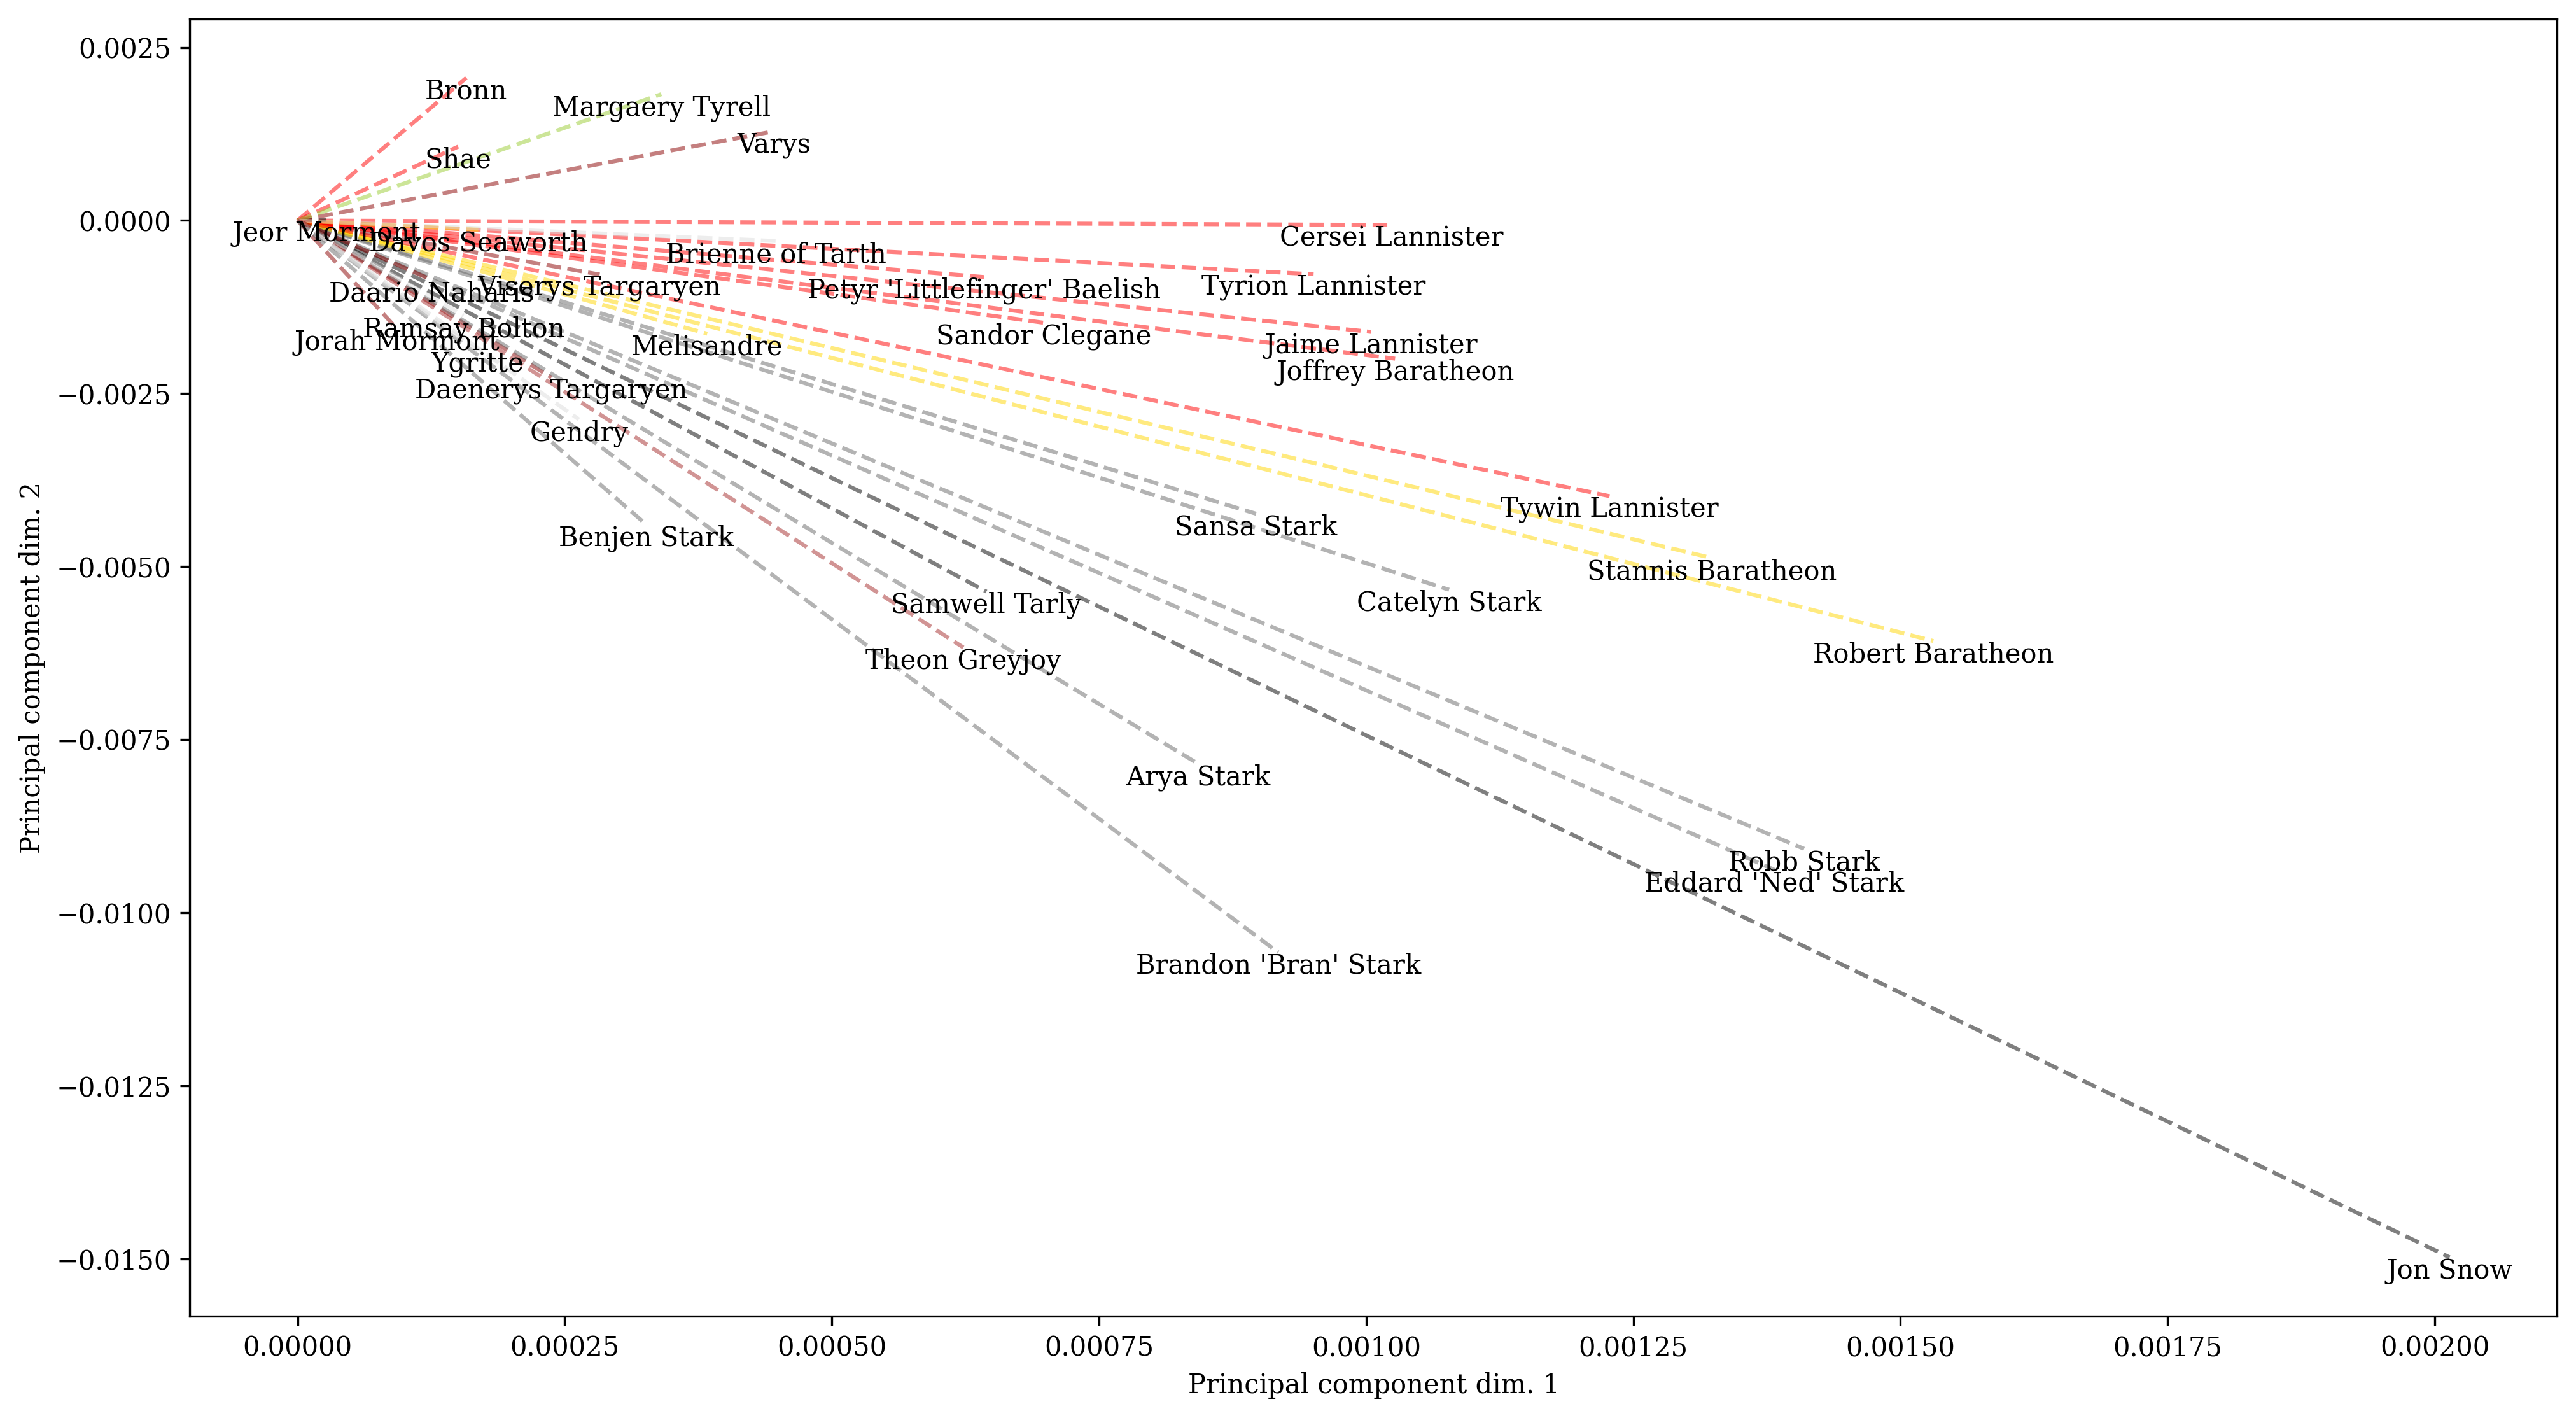

In [164]:
plot_arrows(Z_book)

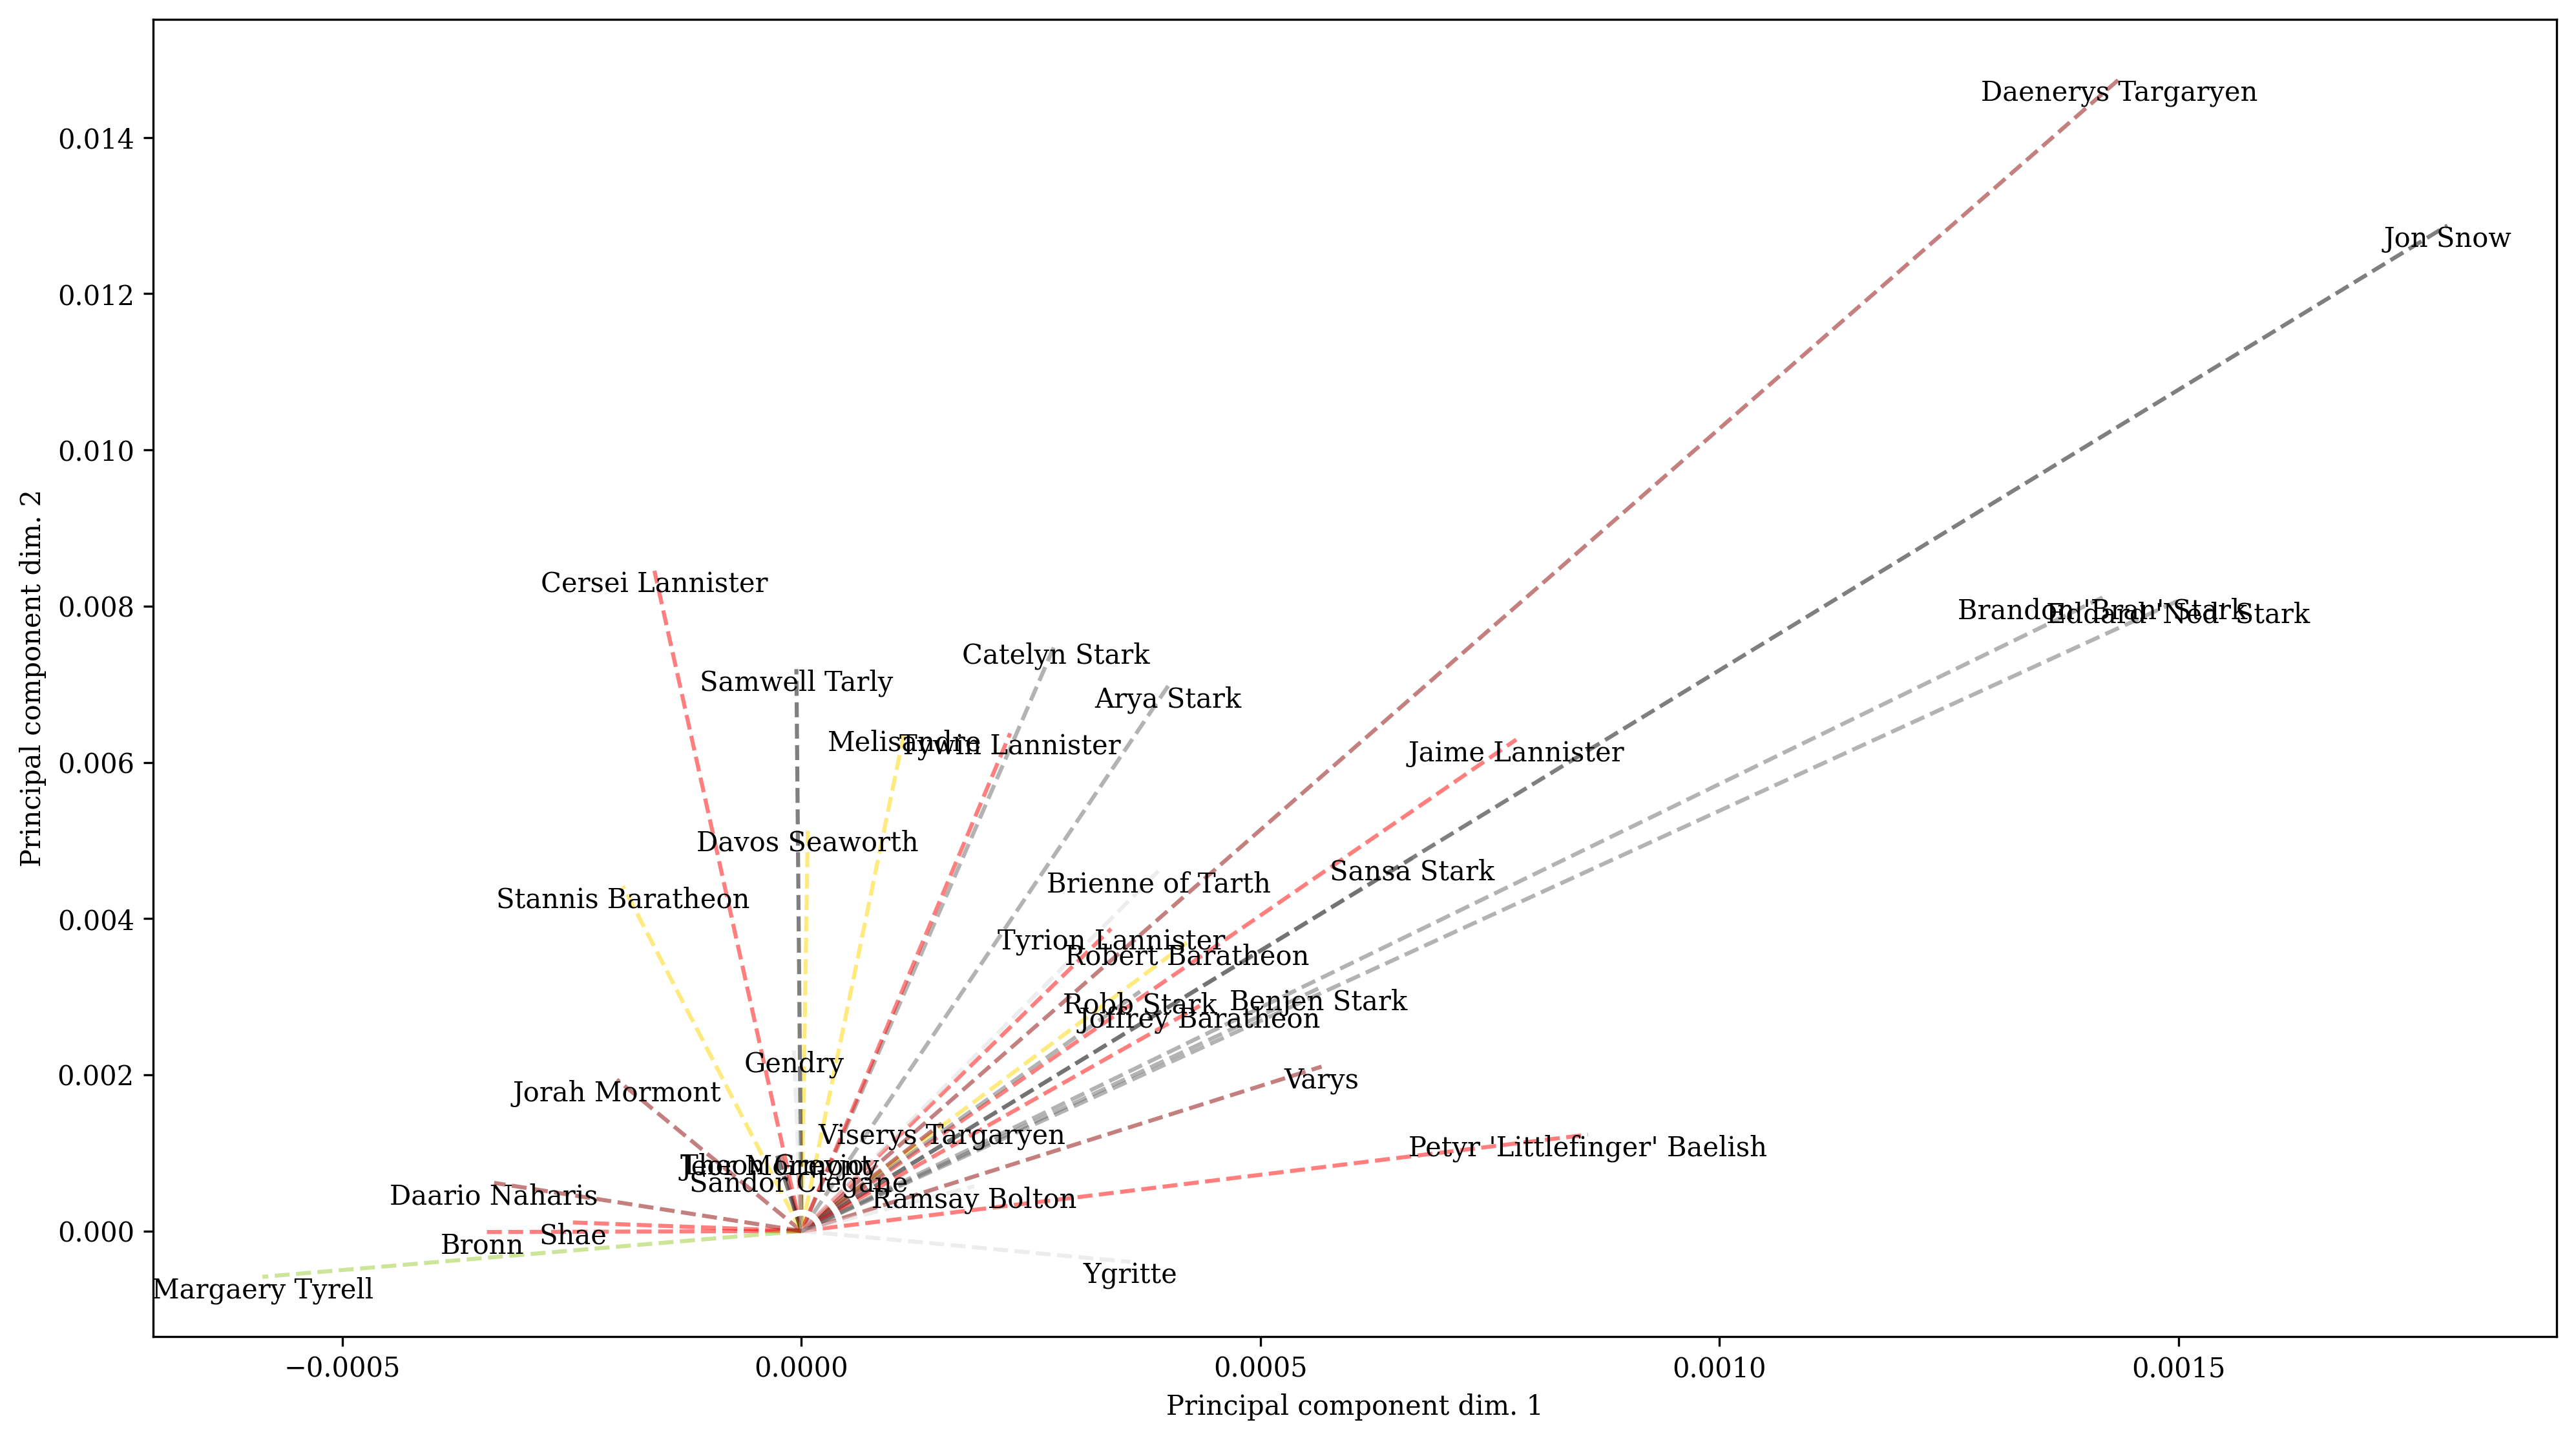

In [165]:
plot_arrows(Z_reddit)

## 4. What do we understand?

####    What went well?
We believe that of the best results from this project is the results of sentiment analysis, PCA and community detection. In the sentiment analysis, we clearly see that stereotypically hated and loved characters have low and high sentiment respectively on both of the measures. The PCA also shows much more effectively than expected how the different factions are split up. Lastly, we see that community detection successfully finds that characters from the noth, east and south should be turned into different communities in the book, while the reddit data mostly shows that the main characters are often mentioned in the same posts. All of these results are quite intuitive.

####    What is still missing? What could be improved?, Why?
The biggest issue is our method for selecting the the text in the document of each character - especially in the book data: Our very crude method of giving the entire chapter or post to every character that appears in it might explain some issues in the NLP results such as the very similar word clouds. Further work would require a much more fine-grained division such as a moving window over the words that give the entire sequence in the window to every character that appears in it. This would add a new hyper parameter in the window size which we did end up having time to test out in this project.

We would also have liked to look at how the sentiment changed on the subreddit prior and after the release of the different seasons of the tv-show of the book series. Our initial hypothesis of this is that the semantic changed dramaticaclly as season 8 progressed. If time would allow, a classifier could also have been trained to classify the characters that were mentioned in the post based on a reddit post or written input from the user.

A more complete approach to answer the questions posed in the motivation would also include more traditional methods of social science such as questionnaires and interviews with readers.

### Website

We have coded the website in html and all the code is availble in our repository at https://github.com/sorenmulli/graph-of-thrones.